<a href="https://colab.research.google.com/github/jayysinn98/Customer-Segmentation/blob/main/Hackathon_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Data Loading

In [138]:
import sys
!conda install --yes --prefix {sys.prefix} plotly
!pip install kmodes
!{sys.executable} -m pip install kmodes
from kmodes.kprototypes import KPrototypes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.io as pio
import datetime
pio.renderers.default = 'colab' 

/bin/bash: conda: command not found


In [139]:
url='https://drive.google.com/file/d/1U1ZO1C8ksG72URGVGv9TyUDCrM52tgKw/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

url1='https://drive.google.com/file/d/1K4AXXyuhHH3Nt-SgOmfosqvou2Gl4BXG/view?usp=sharing'
path1 = 'https://drive.google.com/uc?export=download&id='+url1.split('/')[-2]

url2='https://docs.google.com/spreadsheets/d/11T71DVKhfZVLirg2IC-6_oRvEurV3F1G/edit?usp=sharing&ouid=110431170481092756364&rtpof=true&sd=true'
path2 = 'https://drive.google.com/uc?export=download&id='+url2.split('/')[-2]

url3 = 'https://docs.google.com/spreadsheets/d/1h8pY7VAlmDG_aK7MpMWcv5698ZW9gD_Q/edit?usp=sharing&ouid=110431170481092756364&rtpof=true&sd=true'
path3 = 'https://drive.google.com/uc?export=download&id='+url3.split('/')[-2]

transaction_df = pd.read_csv(path)
categories = pd.read_csv(path1)
panelists_demogs = pd.read_excel(path2)
survey = pd.read_excel(path3, sheet_name = 'Raw Responses')

pd.options.mode.chained_assignment = None

## 2. Data Processing and Exploration

### 2.1 Transaction Data

In [140]:
transaction_df.info()
transaction_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1389941 entries, 0 to 1389940
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Panel ID   1389941 non-null  float64
 1   Date       1389941 non-null  object 
 2   Category   1389941 non-null  object 
 3   Pack Size  1389941 non-null  float64
 4   Volume     1389941 non-null  float64
 5   Spend      1389941 non-null  float64
dtypes: float64(4), object(2)
memory usage: 63.6+ MB


(1389941, 6)

In [141]:
#check for duplicated rows
transaction_df.duplicated().sum()

46413

There are 46413 duplicated rows but we decided not to drop them because it is possible that the same panelist purchased the same amount of one particular good more than once on the same date.

In [142]:
transaction_df.head()

,Panel ID,Date,Category,Pack Size,Volume,Spend
0,101011101.0,2018-04-29,SUGAR,2.0,2.0,5.9
1,101011101.0,2018-04-29,COCONUT MILK,3.0,0.6,9.6
2,101011101.0,2018-05-06,CAKE,1.0,0.2,5.0
3,101011101.0,2018-05-06,CAKE,1.0,0.5,5.0
4,101011101.0,2018-05-06,SEASONING POWDER,2.0,0.1,4.2


In [143]:
transaction_df['Pack Size'].value_counts()

1.0      1026855
2.0       238870
3.0        52483
4.0        30833
5.0        14683
          ...   
46.0           1
54.0           1
77.0           1
55.0           1
117.0          1
Name: Pack Size, Length: 127, dtype: int64

In [144]:
#converting class of panel id to string and class of date to datetime
transaction_df['Panel ID'] = transaction_df['Panel ID'].astype(int).astype(str)
panelists_demogs['ID'] = panelists_demogs['ID'].astype(str)
transaction_df['Date'] = pd.to_datetime(transaction_df['Date'], format= '%Y-%m-%d')

In [145]:
print('First recorded purchase: {0}'.format(transaction_df['Date'].min()))
print('Last recorded purchase: {0}'.format(transaction_df['Date'].max()))
print('Time between last and first purchase: {0}'.format(transaction_df['Date'].max() - transaction_df['Date'].min()))

First recorded purchase: 2018-04-29 00:00:00
Last recorded purchase: 2021-04-25 00:00:00
Time between last and first purchase: 1092 days 00:00:00


In [146]:
#some transactions had 0 recorded for spend and some had 0 recorded for volume 
#there are 52375 rows where spend==0 or volume==0
transaction_df[(transaction_df['Spend']==0.0) | (transaction_df['Volume']==0.0)]


,Panel ID,Date,Category,Pack Size,Volume,Spend
47,101011101,2018-08-19,COOKING SAUCES,1.0,0.0,1.6
124,101011101,2019-03-17,COOKING SAUCES,1.0,0.0,1.2
299,101011101,2020-08-30,SEASONING POWDER,1.0,0.0,1.0
315,101011101,2020-10-04,SEASONING POWDER,2.0,0.0,2.8
329,101011101,2020-11-22,CONFECTIONERY,2.0,0.0,5.7
...,...,...,...,...,...,...
1389807,802307401,2021-04-04,ICE CREAM,5.0,0.0,5.0
1389814,802307401,2021-04-11,ICE CREAM,5.0,0.0,5.0
1389817,802307401,2021-04-18,ICE CREAM,4.0,0.0,4.0
1389922,802315101,2021-04-25,COOKING SAUCES,1.0,0.0,1.8


In [147]:
#we remove the 52375 rows where spend==0 or volume==0
transaction_df = transaction_df[(transaction_df['Spend']!=0.0) & (transaction_df['Volume']!=0.0)]

Adding Weight variable:

In [148]:
transaction_df1 = transaction_df

#create a new weight column (unit: kg)
transaction_df1['Weight'] = transaction_df1['Volume']
#for most of the categories (dry food), the volume is already in kg
#for liquids/drinks, the volume is litre, and since 1L weighs approx. 1kg for most liquids, we can use the same numerical values directly

#for ice cream, 1L weighs approx. 600g
transaction_df1.loc[(transaction_df1['Category']=='ICE CREAM'), 'Weight'] = transaction_df1[transaction_df1['Category']=='ICE CREAM']['Volume']*0.6

#for instant noodles, we assume that volume corresponds to 1 pack of noodles, which is around 100g
transaction_df1.loc[(transaction_df1['Category']=='Instant Noodles'), 'Weight'] = transaction_df1[transaction_df1['Category']=='Instant Noodles']['Volume']*0.1

#for eggs, we assume that volume corresponds to 1 pack of 10 eggs, which is around 500g
transaction_df1.loc[(transaction_df1['Category']=='EGGS'), 'Weight'] = transaction_df1[transaction_df1['Category']=='EGGS']['Volume']*0.5


Adding Time Elapsed Variable:
(since time duration of transaction data for each ID varies significantly)

In [149]:
#create new column for time_elapsed for each Panel ID
time_elapsed = pd.DataFrame(transaction_df1.groupby('Panel ID')['Date'].max()
                            -transaction_df1.groupby('Panel ID')['Date'].min())
time_elapsed.reset_index()

#rename column
time_elapsed.rename(columns={'Date': 'Time Elapsed'}, inplace=True)

In [150]:
#add time_elapsed column to transaction_df1 
transaction_df1 = pd.merge(transaction_df1, time_elapsed, on='Panel ID', how='inner')

#(max date - min date + 1) 
transaction_df1['Time Elapsed'] = (transaction_df1['Time Elapsed']/np.timedelta64(1, 'D')).astype(int)+1

### 2.2 Categories Data

In [151]:
categories.info()
categories.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Category          62 non-null     object 
 1   Calories/100g     62 non-null     int64  
 2   Price per Volume  62 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ KB


(62, 3)

In [152]:
#check for duplicated rows
np.where(categories['Category'].duplicated())
#no duplicated category

(array([], dtype=int64),)

In [153]:
categories.head()

,Category,Calories/100g,Price per Volume
0,Beer,43,14.16
1,Belacan,563,43.11
2,Bird Nest,46,90.33
3,Biscuits,416,15.72
4,Bouilon,16,28.93


In [154]:
#converting category to capital letters
categories['Category'] = categories['Category'].apply(lambda Category : Category.upper())

In [155]:
transaction_df['Category'].nunique()

61

In [156]:
#check which categories are in 'categories' but not in 'transaction_df'
checker = np.array(categories['Category'].isin(transaction_df['Category']))
np.where(checker==False)

(array([27]),)

In [157]:
categories['Category'].iloc[27]
#we found out that 'transaction_df' does not contain any purchase that belongs to category 'FLOUR'

'FLOUR'

In [158]:
#check which categories are in 'transaction_df' but not in 'categories'
checker1 = np.array(transaction_df['Category'].isin(categories['Category']))
np.where(checker1==False)
#all catrgories in 'transaction_df' are in 'categories'

(array([], dtype=int64),)

Adding indicator variable for whether a catrgory belongs to discretionary food groups (i.e. should restrict consumption):

In [159]:
#based on HPB recommendations, 
#these categories belong to discretionary food groups (i.e. should restrict consumption)
discretionary_food_list = ['BELACAN', 'BISCUITS', 'BOUILON', 'CAKE', 'CEREAL BEVERAGE', 'CHOC/NUT SPREAD', 
                          'CONDENSED/EVAP MILK', 'CONFECTIONERY', 'COOKING SAUCES', 'CORDIALS', 'CREAMER',
                          'CSD', 'ICE CREAM', 'INSTANT NOODLES', 'INSTANT SOUP', 'JAM', 'KAYA', 'MARGARINE',
                          'PEANUT BUTTER', 'SNACK', 'SAVOURY SPREAD']

In [160]:
#create new column: indicator variable (whether in discretionary food group)
categories['Discretionary'] = 0
for i in categories['Category']:
    if i in discretionary_food_list:
        categories.loc[categories['Category']==i, 'Discretionary'] = 1

categories.head()   

,Category,Calories/100g,Price per Volume,Discretionary
0,BEER,43,14.16,0
1,BELACAN,563,43.11,1
2,BIRD NEST,46,90.33,0
3,BISCUITS,416,15.72,1
4,BOUILON,16,28.93,1


### 2.3 Panelist Demographics Data

In [161]:
panelists_demogs.info()
panelists_demogs.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3918 entries, 0 to 3917
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3918 non-null   object
 1   BMI        3918 non-null   object
 2   Ethnicity  3918 non-null   object
 3   Strata     3918 non-null   object
 4   Location   3918 non-null   object
 5   Lifestage  3918 non-null   object
 6   #HH        3918 non-null   object
 7   Income     3918 non-null   object
dtypes: object(8)
memory usage: 245.0+ KB


(3918, 8)

In [162]:
#check for duplicated rows/IDs
print(panelists_demogs.duplicated().sum())
print(panelists_demogs['ID'].nunique())
#no duplicates

0
3918


In [163]:
panelists_demogs.head()

,ID,BMI,Ethnicity,Strata,Location,Lifestage,#HH,Income
0,Panel 101011101,Obese,Malay,Urban,North,Empty Nesters,1-3 Member HH,<RM2000 (Low)
1,Panel 101016101,Healthy,Malay,Urban,North,Yankys/Matured Families,1-3 Member HH,<RM2000 (Low)
2,Panel 101019101,Obese,Malay,Urban,North,Teens Aches,4-5 Member HH,<RM2000 (Low)
3,Panel 101024101,Over Weight,Chinese,Urban,North,Nesting Families,1-3 Member HH,<RM2000 (Low)
4,Panel 105009103,Over Weight,Malay,Rural,North,Empty Nesters,1-3 Member HH,<RM2000 (Low)


In [164]:
#to make sure that 'ID' in 'panelists_demogs' can match 'Panel ID' in 'transaction_df'
panelists_demogs['ID'] = panelists_demogs['ID'].str.replace('Panel ', '')
panelists_demogs = panelists_demogs.rename(columns={'ID': 'Panel ID'})

#### Correlation among demographics variables

Recoding categorical variables in demographics dataframe into ordered and dummy variables to check for correlation among them:

In [165]:
def BMI_recode(BMI):
    if BMI == "Under Weight":
      return 1
    elif BMI == "Healthy":
      return 2
    elif BMI == "Over Weight":
      return 3
    else:
      return 4

def income_recode(income):
    if income == "<RM2000 (Low)":
      return 1
    elif income == "RM2000-RM2999 (Low High)":
      return 2
    elif income == "RM3000-RM4999 (Mid Low)":
      return 3
    elif income == "RM5000-RM7999 (Mid High)":
      return 4
    else:
      return 5

def HH_recode(HH):
    if HH == "1-3 Member HH":
      return 1
    elif HH == "4-5 Member HH":
      return 2
    else:
      return 3


def life_stage_recode(life_stage):
    if life_stage == "Teens and Toddlers":
      return 1
    elif life_stage == "Teens Aches":
      return 2
    elif life_stage == "Nesting Families":
      return 3
    elif life_stage == "Yankys/Matured Families":
      return 4
    else:
      return 5 

In [166]:
demogs1 = panelists_demogs[panelists_demogs['BMI']!='Not Available']

In [167]:
demogs1 = panelists_demogs[panelists_demogs['BMI']!='Not  Available']

demogs1.loc[:,'BMI'] = demogs1.loc[:,'BMI'].apply(BMI_recode)

demogs1['Income'] = demogs1['Income'].apply(income_recode)

demogs1['HH'] = demogs1['#HH'].apply(HH_recode)

demogs1['Lifestage'] = demogs1['Lifestage'].apply(life_stage_recode)

demogs1['Ethnicity_Dummy_M'] = demogs1['Ethnicity'].apply(lambda x: 1 if x == 'Malay' else 0)
demogs1['Ethnicity_Dummy_C'] = demogs1['Ethnicity'].apply(lambda x: 1 if x == 'Chinese' else 0)

demogs1['Strata_Dummy'] = demogs1['Strata'].apply(lambda x: 1 if x == 'Urban' else 0)

demogs1['Location_Dummy_N'] = demogs1['Location'].apply(lambda x: 1 if x == 'North' else 0)
demogs1['Location_Dummy_S'] = demogs1['Location'].apply(lambda x: 1 if x == 'South' else 0)
demogs1['Location_Dummy_C'] = demogs1['Location'].apply(lambda x: 1 if x == 'Central' else 0)



In [168]:
demogs1.drop(['#HH','Panel ID','Location', 'Ethnicity', 'Strata'], axis=1, inplace=True)
demogs1

,BMI,Lifestage,Income,HH,Ethnicity_Dummy_M,Ethnicity_Dummy_C,Strata_Dummy,Location_Dummy_N,Location_Dummy_S,Location_Dummy_C
0,4,5,1,1,1,0,1,1,0,0
1,2,4,1,1,1,0,1,1,0,0
2,4,2,1,2,1,0,1,1,0,0
3,3,3,1,1,0,1,1,1,0,0
4,3,5,1,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
3913,4,3,4,2,1,0,1,0,0,1
3914,4,1,3,3,1,0,1,0,0,1
3915,4,1,4,3,1,0,1,1,0,0
3916,4,2,4,2,1,0,1,0,0,1


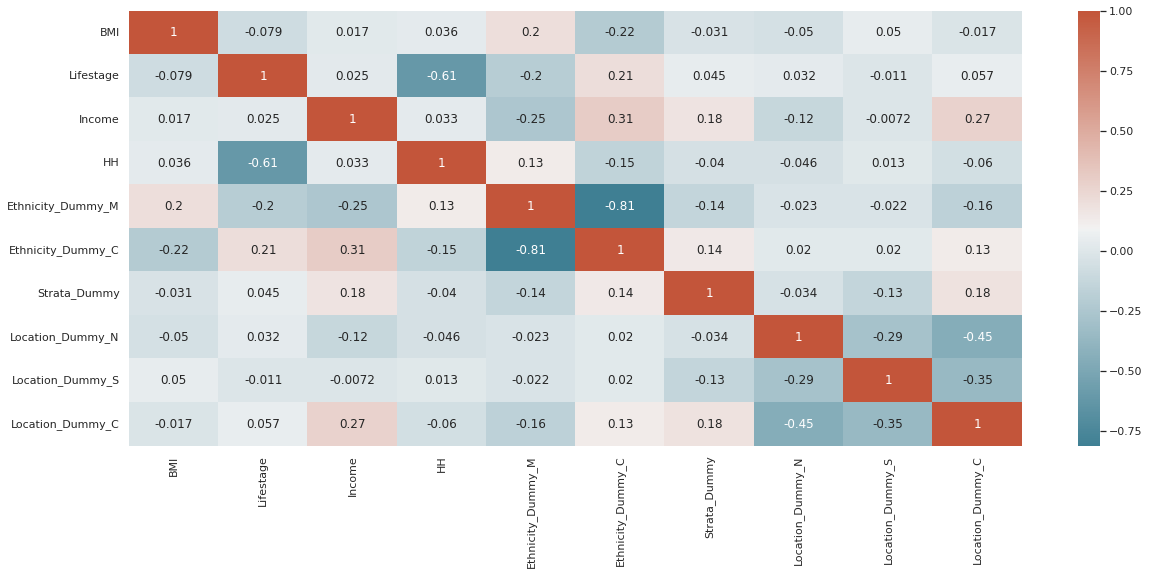

In [169]:
# calculate correlation matrix
corr = demogs1.corr()# plot the heatmap

fig, ax = plt.subplots(figsize=(20, 8))
corr = demogs1.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
               annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.show()

We choose to drop the #HH variable because it is positively correlated with life stage.


####KModes to relabel BMI "Not Available"

In [170]:
from kmodes.kmodes import KModes

First, we have to drop the BMI labels and set the Panel ID as the index

In [171]:
#new dataframe for relabelled BMI
panelists_demogs1 = panelists_demogs.set_index('Panel ID')
bmi_labels = panelists_demogs1['BMI']
panelists_demogs1 = panelists_demogs1.drop(columns = ['BMI', '#HH'])

Find the ideal number of clusters using WCSS

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 10174.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 10174.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 10174.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 10174.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 10174.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 0, cost: 10174.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 0, cost: 10174.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 8, iteration:

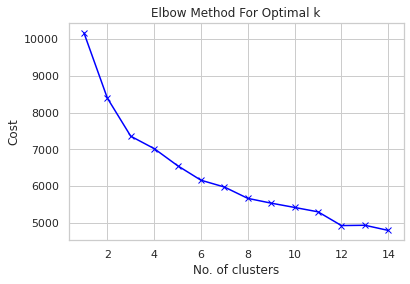

In [172]:
cost = []
K = range(1,15)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 10, verbose=1)
    kmode.fit_predict(panelists_demogs1)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

**So** the ideal no. of clusters is 6.

In [173]:
kmode = KModes(n_clusters=6, init = "random", n_init = 10, verbose=1)
clusters = kmode.fit_predict(panelists_demogs1)
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 640, cost: 6747.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1233, cost: 6296.0
Run 2, iteration: 2/100, moves: 2, cost: 6296.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 1326, cost: 6161.0
Run 3, iteration: 2/100, moves: 105, cost: 6161.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1107, cost: 6198.0
Run 4, iteration: 2/100, moves: 206, cost: 6198.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 789, cost: 6516.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 497, cost: 6770.0
Init: initializing centroids
Init: initializing clusters
Starting ite

array([0, 0, 0, ..., 0, 5, 5], dtype=uint16)

After getting the cluster labels for the Panel IDs, we reattach them and their BMI labels to the original demographics dataframe

In [174]:
panelists_demogs1.insert(0, "BMI", bmi_labels, True)
panelists_demogs1.insert(0, "Cluster", clusters, True)
panelists_demogs1

,Cluster,BMI,Ethnicity,Strata,Location,Lifestage,Income
Panel ID,,,,,,,
101011101,0,Obese,Malay,Urban,North,Empty Nesters,<RM2000 (Low)
101016101,0,Healthy,Malay,Urban,North,Yankys/Matured Families,<RM2000 (Low)
101019101,0,Obese,Malay,Urban,North,Teens Aches,<RM2000 (Low)
101024101,2,Over Weight,Chinese,Urban,North,Nesting Families,<RM2000 (Low)
105009103,3,Over Weight,Malay,Rural,North,Empty Nesters,<RM2000 (Low)
...,...,...,...,...,...,...,...
802312801,5,Not Available,Malay,Urban,Central,Nesting Families,RM5000-RM7999 (Mid High)
802313601,5,Not Available,Malay,Urban,Central,Teens and Toddlers,RM3000-RM4999 (Mid Low)
802314001,0,Not Available,Malay,Urban,North,Teens and Toddlers,RM5000-RM7999 (Mid High)


In [175]:
cluster1 = panelists_demogs1[panelists_demogs1['Cluster'] == 1]
cluster2 = panelists_demogs1[panelists_demogs1['Cluster'] == 2]
cluster3 = panelists_demogs1[panelists_demogs1['Cluster'] == 3]
cluster4 = panelists_demogs1[panelists_demogs1['Cluster'] == 4]
cluster5 = panelists_demogs1[panelists_demogs1['Cluster'] == 5]
cluster6 = panelists_demogs1[panelists_demogs1['Cluster'] == 6]

In [176]:
cluster1['BMI'].value_counts()

Not Available    174
Healthy          166
Over Weight      134
Obese             76
Under Weight      69
Name: BMI, dtype: int64

All clusters have 'Healthy' BMI as the majority label. Thus, all 'Not Available' BMI shall be relabelled to 'Healthy'.

In [177]:
panelists_demogs1['BMI'] = panelists_demogs1['BMI'].map(lambda x : 'Healthy' if x == 'Not Available' else x)

### 2.4 Survey Data

In [178]:
survey.info()
survey.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1891 entries, 0 to 1890
Columns: 261 entries, ID to v_333
dtypes: float64(252), object(9)
memory usage: 3.8+ MB


(1891, 261)

In [179]:
#check for duplicated rows/IDs
print(survey.duplicated().sum())
print(survey['ID'].nunique())
#no duplicates

0
1891


In [180]:
survey.head()

,ID,v_16,v_17,v_18,v_19,v_20,v_21,v_22,v_23,v_24,v_25,v_26,v_27,v_28,v_29,v_30,v_31,v_32,v_33,v_34,v_35,v_36,v_37,v_38,v_39,v_40,v_41,v_42,v_43,v_44,v_45,v_46,v_47,v_48,v_49,v_50,v_51,v_52,v_53,v_54,...,dupl1_v_209,v_600,dupl1_v_210,dupl1_v_211,dupl1_v_212,v_213,v_214,v_215,dupl1_v_216,v_761,v_762,v_763,v_764,v_765,v_767,v_768,v_770,v_771,v_772,v_773,v_774,v_775,dupl1_v_222,dupl1_v_223,v_1154,dupl1_v_229,v_777,v_778,v_779,v_780,v_304,v_305,v_306,v_307,v_308,v_309,v_310,v_311,v_312,v_333
0,426187101.0,1.0,3.0,4.0,1.0,3.0,4.0,1.0,1.0,1.0,1.0,4.0,4.0,1.0,1.0,3.0,4.0,1.0,1.0,1.0,1.0,4.0,4.0,1.0,1.0,3.0,4.0,1.0,1.0,1.0,1.0,4.0,4.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,...,0.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,3.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0
1,203116101.0,1.0,3.0,3.0,1.0,2.0,2.0,2.0,3.0,3.0,4.0,4.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,3.0,4.0,4.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,3.0,4.0,4.0,2.0,1.0,3.0,1.0,3.0,1.0,3.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,4.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0
2,248111101.0,1.0,7.0,7.0,1.0,2.0,2.0,2.0,2.0,3.0,4.0,3.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,4.0,3.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,4.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,4.0,3.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,NaN,6.0,6.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,0.0
3,201019101.0,1.0,7.0,7.0,4.0,4.0,4.0,4.0,3.0,3.0,4.0,4.0,4.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,...,0.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,arena,1.0,4.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0
4,246226102.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0


Need to standardize the values. Some 1s represent frequent, others never, so we make it such that 7 - most frequent / 1 - never/least frequent

In [181]:
def standardize_freq(val) :
    if val == 1 :
        return 7
    elif val == 2 :
        return 6
    elif val == 3 :
        return 5
    elif val == 4 :
        return 4
    elif val == 5 :
        return 3
    elif val == 6 :
        return 2
    else :
        return 1

We first analyze the survey data according to the 5 mediums given : TV, Internet, Radio, Newspaper and E-Wallet. 

We will then compile Panelists' usage for the 5 mediums and combine them into a dataframe.

#### TV Frequency

In [182]:
tv_freq = survey[['v_16']]
tv_freq.columns = ['tv freq']
tv_freq.loc[:,'tv freq'] = tv_freq.loc[:,'tv freq'].map(standardize_freq)

#### Radio Frequency

In [183]:
internet_freq = survey[['v_140']]
internet_freq.columns = ['internet freq']
internet_freq.loc[:,'internet freq'] = internet_freq.loc[:,'internet freq'].map(standardize_freq)

#### Internet Frequency

In [184]:
radio_freq = survey[['v_232']]
radio_freq.columns = ['radio freq']
radio_freq.loc[:,'radio freq'] = radio_freq.loc[:,'radio freq'].map(standardize_freq)

#### Newspaper Frequency

In [185]:
newspaper_freq = survey[['dupl1_v_222']]
newspaper_freq.columns = ['newspaper freq']
newspaper_freq.loc[:,'newspaper freq'] = newspaper_freq.loc[:,'newspaper freq'].map(standardize_freq)

####Merging the Media Data

In [186]:
media_final = pd.concat([survey['ID'].to_frame(),tv_freq, radio_freq, internet_freq, newspaper_freq], axis = 1)
media_final.columns = ['Panel ID','TV','Radio','Internet','Newspaper']
media_final.head()

,Panel ID,TV,Radio,Internet,Newspaper
0,426187101.0,7,4,7,5
1,203116101.0,7,3,7,4
2,248111101.0,7,5,7,2
3,201019101.0,7,7,7,7
4,246226102.0,5,3,7,1


TRIN Score (from Section 2.4)

*   T: TV Frequency
*   R: Radio Frequency
*   I: Internet Frequency
*   N: Newspaper Frequency
> 1: Never/Least Frequent 
> 7: Everyday/Most Frequent







### 2.5 Summary Statistics 

In [187]:
#categories sorted by calories/100g
categories.sort_values(by=['Calories/100g'], ascending=False)

,Category,Calories/100g,Price per Volume,Discretionary
18,COOKING OILS,800,4.04,0
5,BUTTER,720,24.65,0
39,MARGARINE,717,10.10,1
44,PEANUT BUTTER,589,25.37,1
1,BELACAN,563,43.11,1
...,...,...,...,...
4,BOUILON,16,28.93,1
57,TEA,1,38.90,0
15,COFFEE,1,26.44,0
24,DRINKING WATER,0,0.79,0


In [188]:
#categories sorted by Price per Volume
categories.sort_values(by=['Price per Volume'], ascending=False)

,Category,Calories/100g,Price per Volume,Discretionary
54,SPIRITS,250,200.19,0
2,BIRD NEST,46,90.33,0
11,CHICKEN ESSENCE,267,76.52,0
59,WINE,83,67.97,0
41,MILK POWDER-INFANT,450,49.54,0
...,...,...,...,...
35,ISOTONIC DRINKS,27,2.46,0
22,CSD,44,2.15,1
33,INSTANT NOODLES,431,1.08,1
24,DRINKING WATER,0,0.79,0


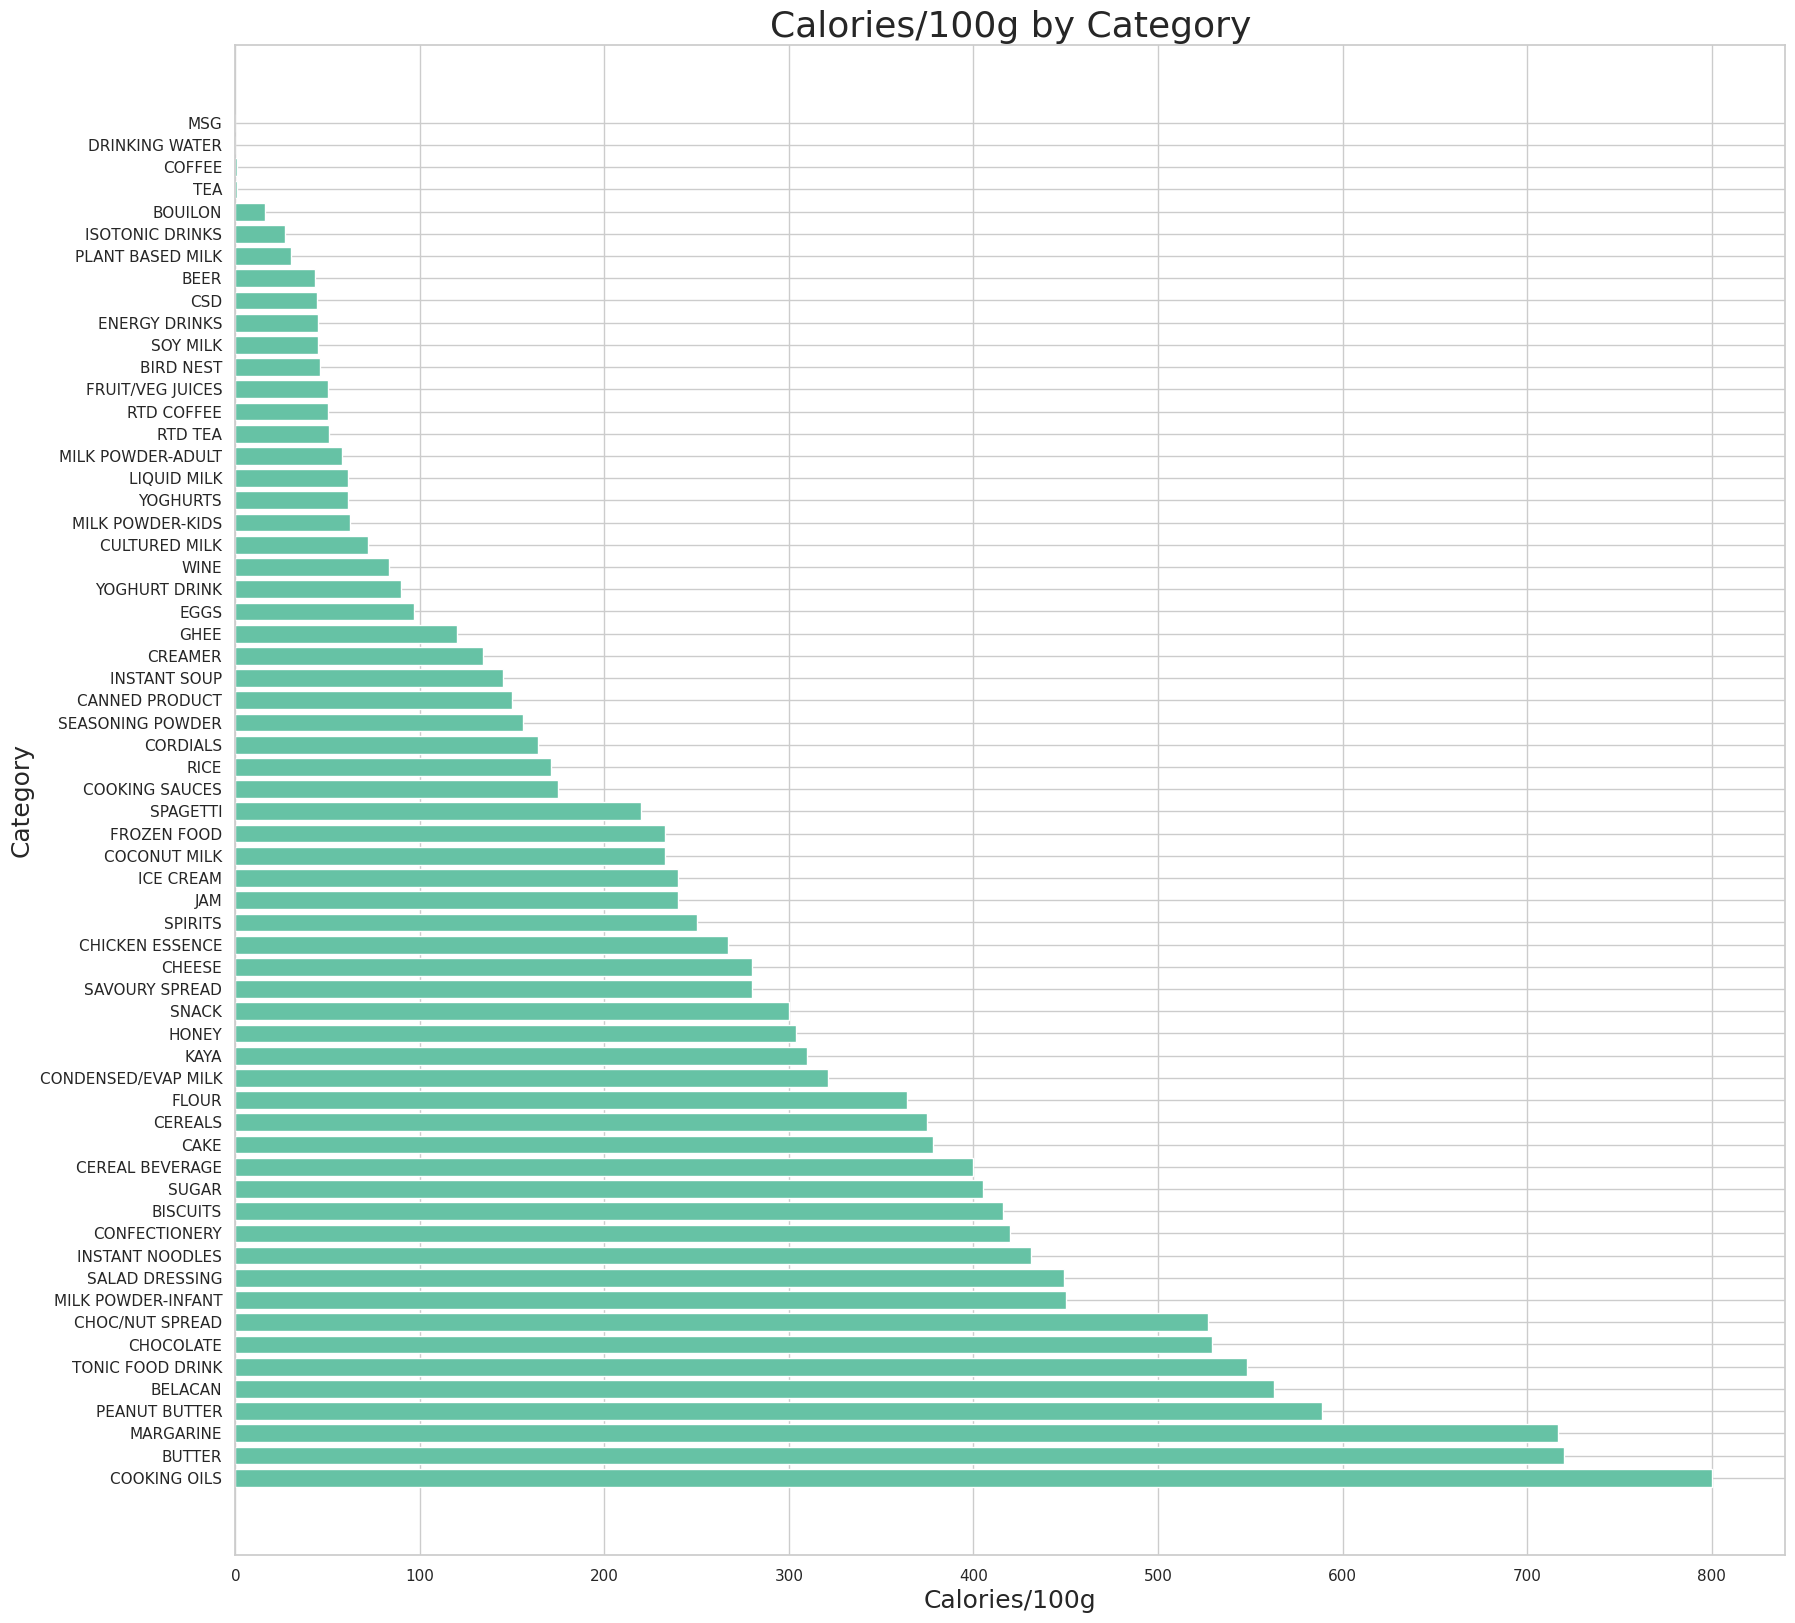

In [189]:
# Bar plot for categories sorted by calories/100g
sns.set_theme(style="whitegrid", palette="Set2")
fig = plt.figure(figsize=(20, 20), dpi=100)
plt.barh('Category', 'Calories/100g',data=categories.sort_values(by=['Calories/100g'], ascending=False))
plt.title("Calories/100g by Category", fontsize=26)
plt.ylabel('Category', fontsize=18)
plt.xlabel('Calories/100g', fontsize=18)
plt.show()

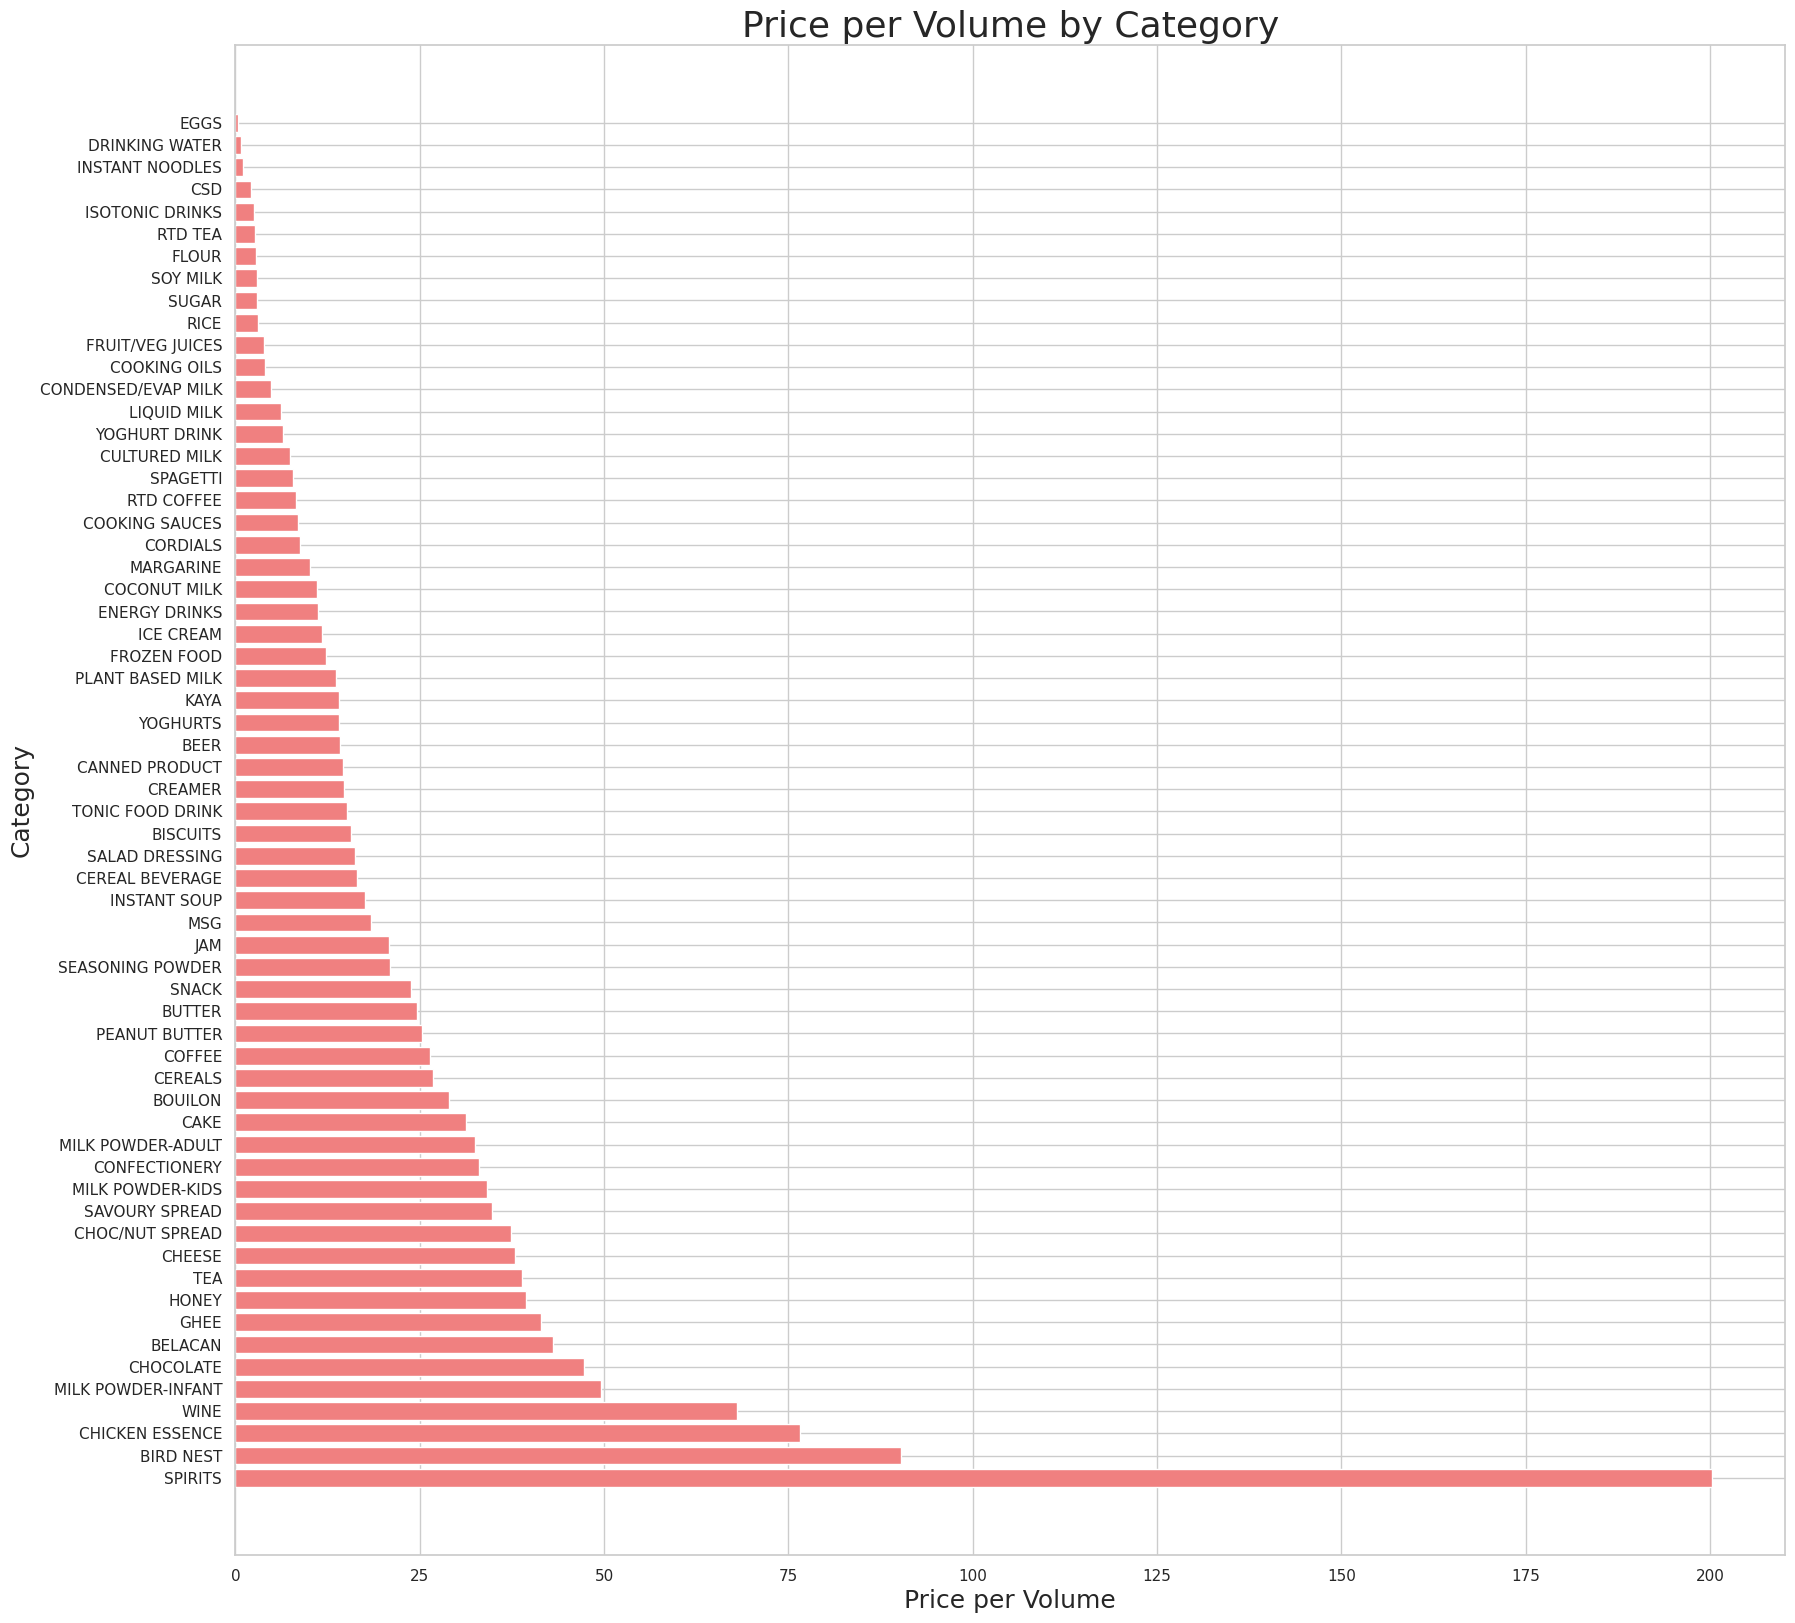

In [190]:
# Bar plot for categories sorted by Price per Volume
fig = plt.figure(figsize=(20, 20), dpi=100)
plt.barh('Category', 'Price per Volume',data=categories.sort_values(by=['Price per Volume'], ascending=False), color='lightcoral')
plt.title("Price per Volume by Category", fontsize=26)
plt.ylabel('Category', fontsize=18)
plt.xlabel('Price per Volume', fontsize=18)
plt.show()

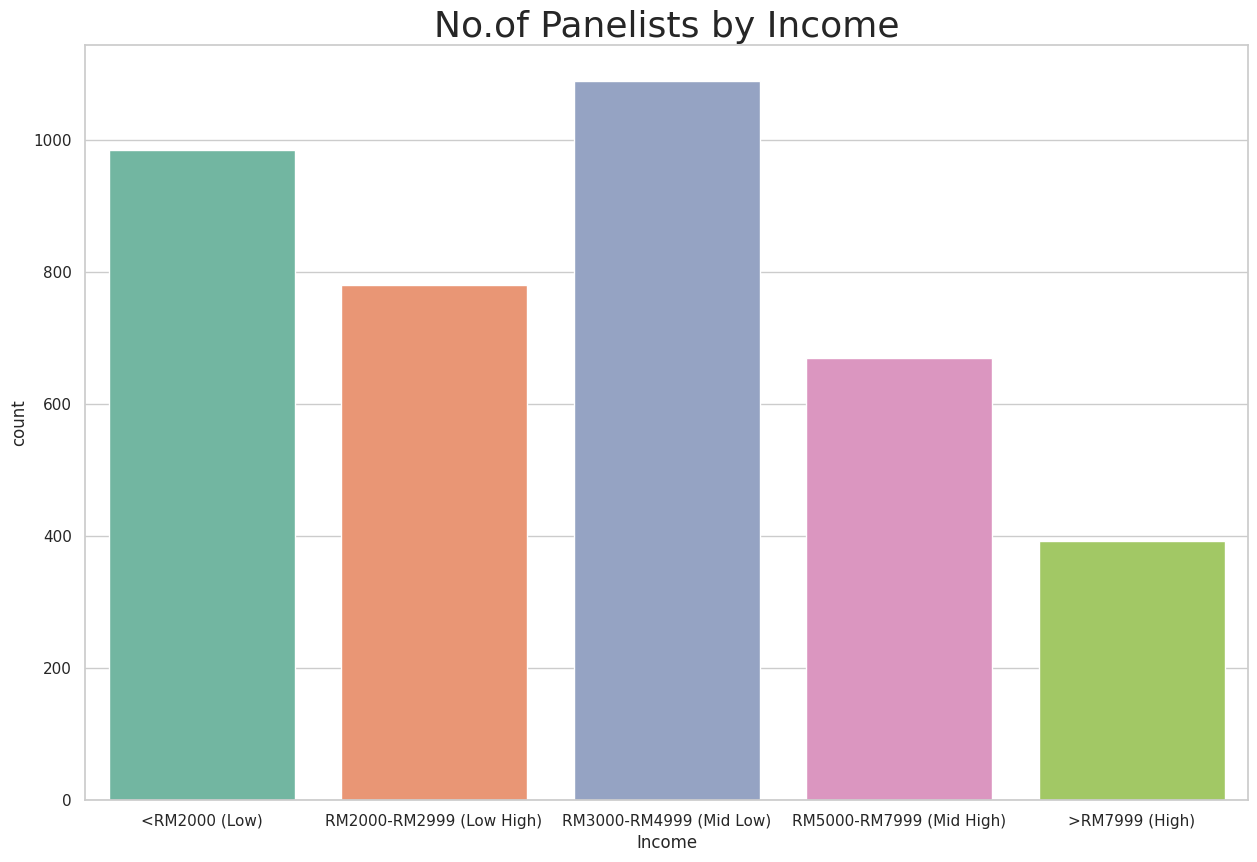

In [191]:
# Bar plot No.of Panelists by Income

fig = plt.figure(figsize=(15, 10), dpi=100)
sns.countplot(x="Income", data=panelists_demogs)
plt.title("No.of Panelists by Income", fontsize=26)
plt.savefig('No.of Panelists by Income.png', dpi=300, bbox_inches='tight')
#files.download('No.of Panelists by Income.png')

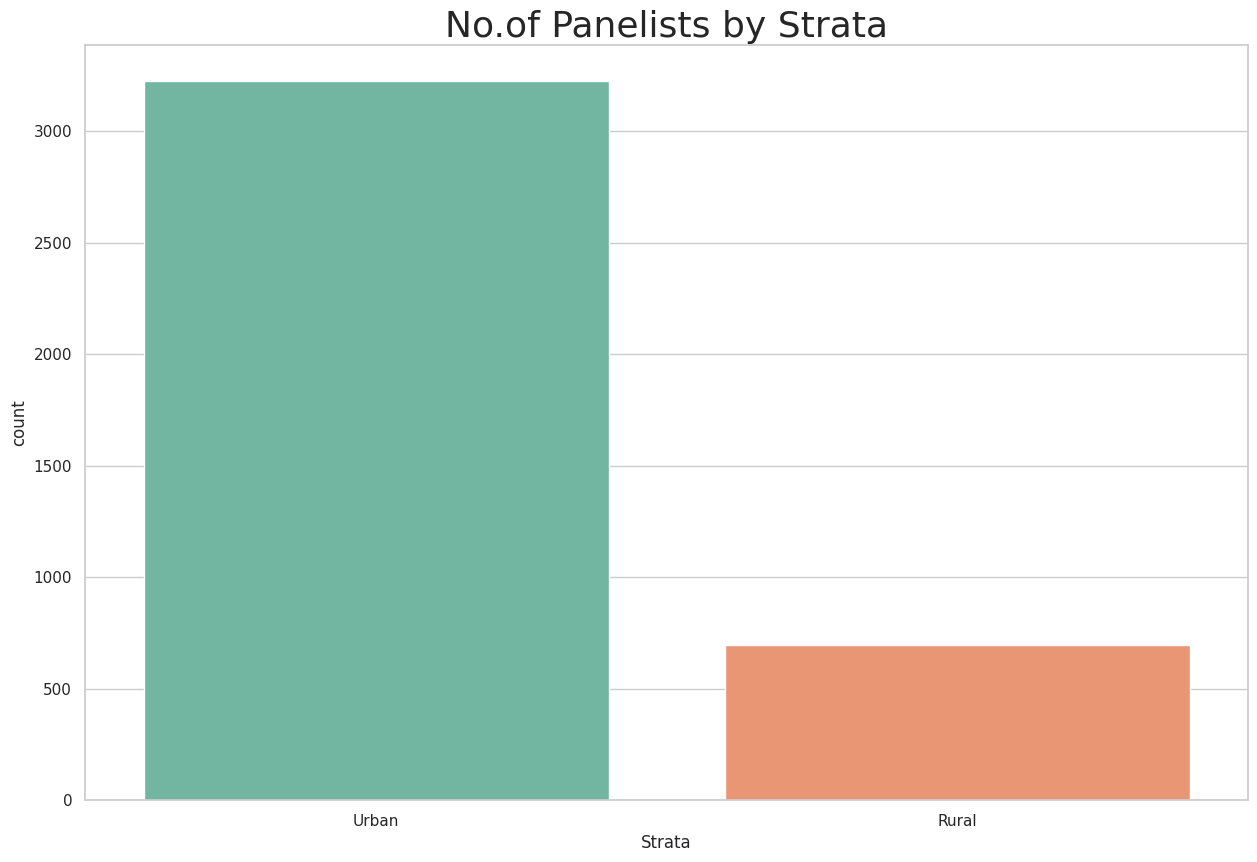

In [192]:
# Bar plot No.of Panelists by Strata

fig = plt.figure(figsize=(15, 10), dpi=100)
sns.countplot(x="Strata", data=panelists_demogs)
plt.title("No.of Panelists by Strata", fontsize=26)
plt.savefig("No.of Panelists by Strata.png", dpi=300, bbox_inches='tight')
#files.download('No.of Panelists by Strata.png')

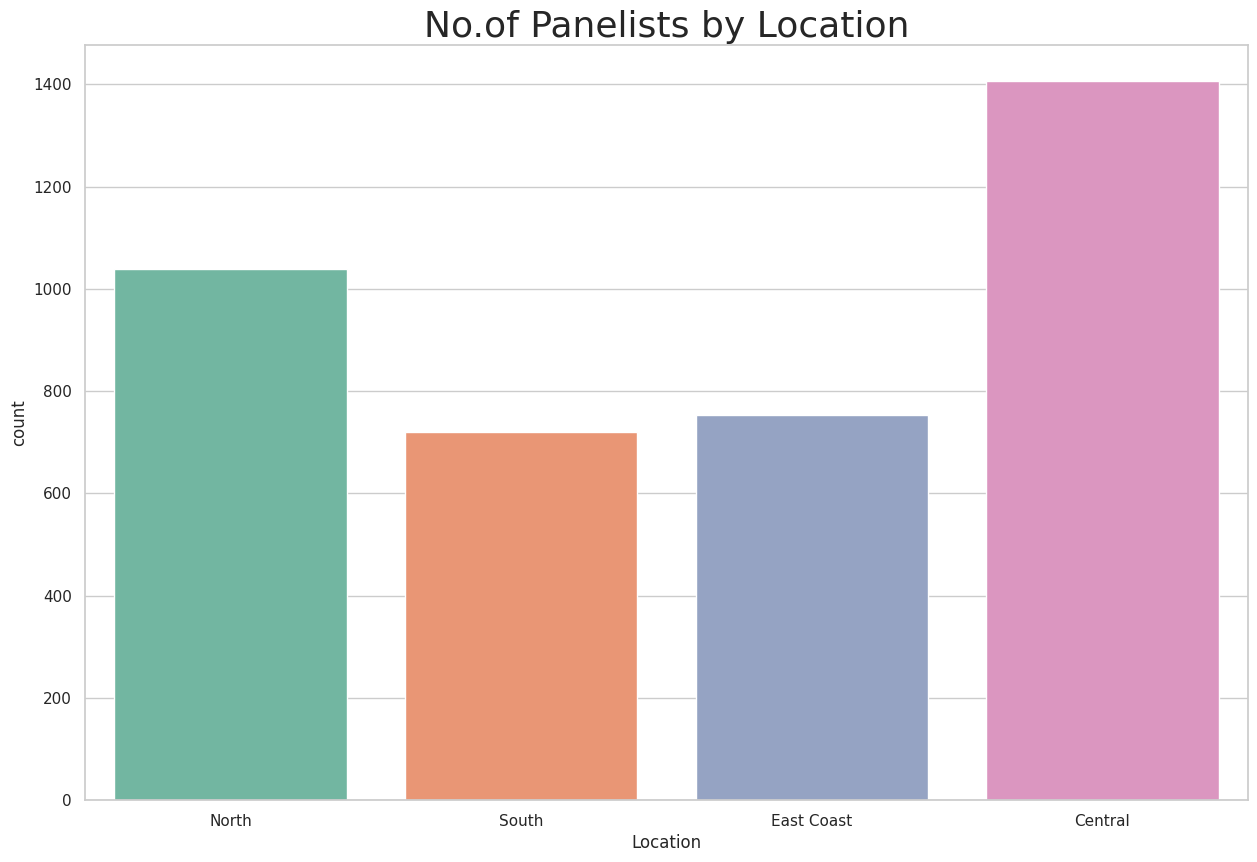

In [193]:
# Bar plot No.of Panelists by Location

fig = plt.figure(figsize=(15, 10), dpi=100)
sns.countplot(x="Location", data=panelists_demogs)
plt.title("No.of Panelists by Location", fontsize=26)
plt.savefig("No.of Panelists by Location.png", dpi=300, bbox_inches='tight')
#files.download('No.of Panelists by Location.png')

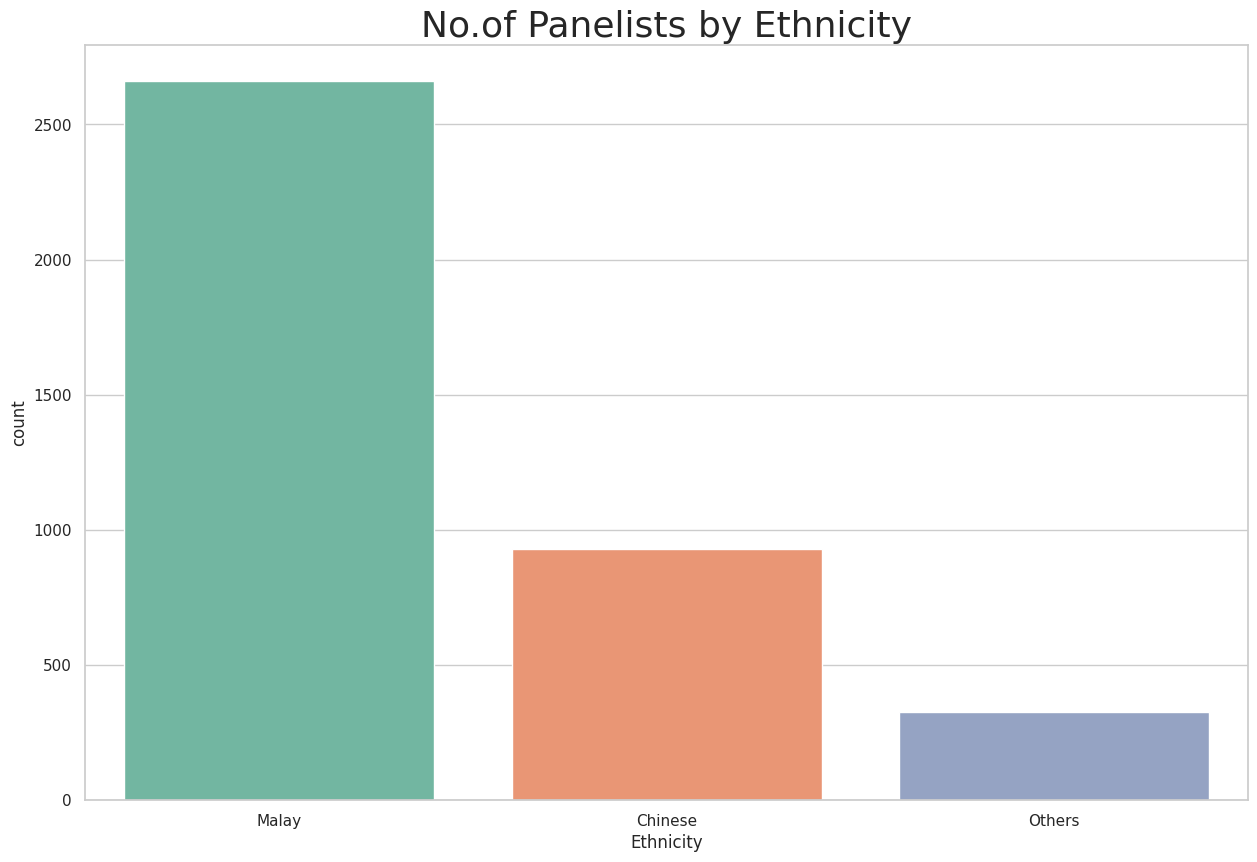

In [194]:
# Bar plot No.of Panelists by Ethnicity

fig = plt.figure(figsize=(15, 10), dpi=100)
sns.countplot(x="Ethnicity", data=panelists_demogs)
plt.title("No.of Panelists by Ethnicity", fontsize=26)
plt.savefig("No.of Panelists by Ethnicity.png", dpi=300, bbox_inches='tight')
#files.download('No.of Panelists by Ethnicity.png')

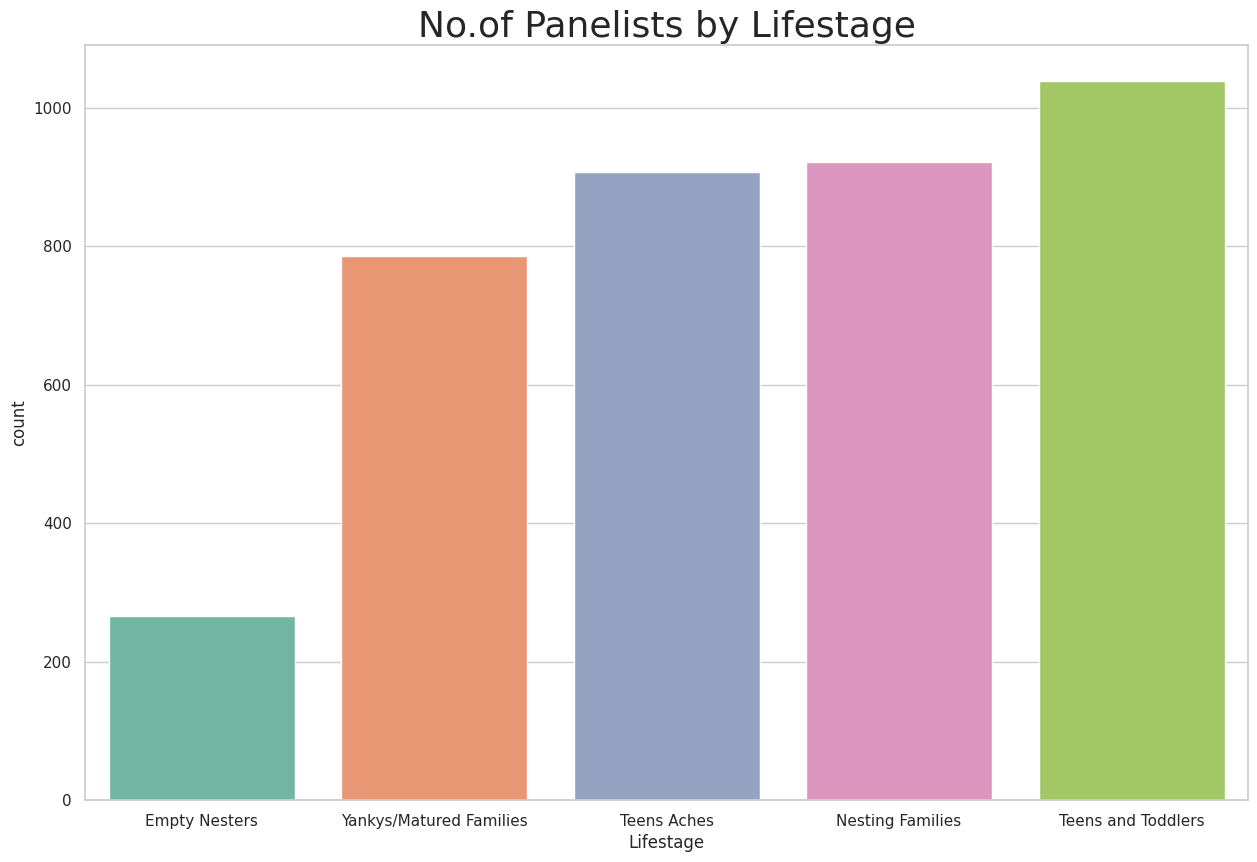

In [195]:
# Bar plot No.of Panelists by Lifestage

fig = plt.figure(figsize=(15, 10), dpi=100)
sns.countplot(x="Lifestage", data=panelists_demogs)
plt.title("No.of Panelists by Lifestage", fontsize=26)
plt.savefig("No.of Panelists by Lifestage.png", dpi=300, bbox_inches='tight')
#files.download('No.of Panelists by Lifestage.png')

In [196]:
panelists_by_income_bmi = panelists_demogs.groupby(['Income','BMI']).size().reset_index(name='counts')
panelists_by_income_bmi = panelists_by_income_bmi.pivot_table('counts', ['Income'],'BMI')

#re-ordering rows and columns
row_index = ['<RM2000 (Low)', 'RM2000-RM2999 (Low High)', 'RM3000-RM4999 (Mid Low)', 'RM5000-RM7999 (Mid High)','>RM7999 (High)']
panelists_by_income_bmi = panelists_by_income_bmi.reindex(row_index)
panelists_by_income_bmi = panelists_by_income_bmi.reindex(['Not Available', 'Under Weight', 'Healthy', 'Over Weight', 'Obese'], axis=1)

<Figure size 2000x2000 with 0 Axes>

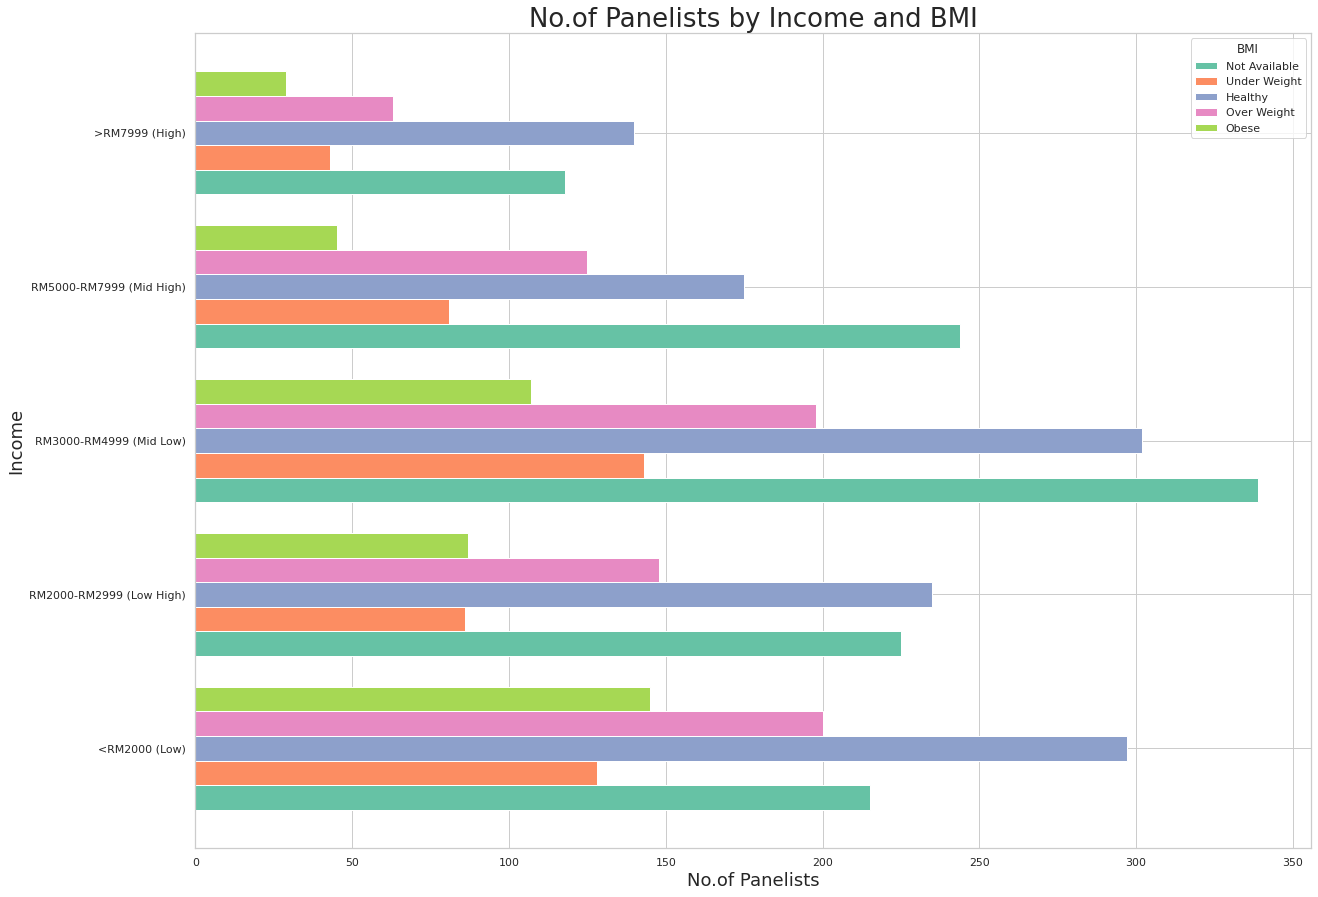

<Figure size 432x288 with 0 Axes>

In [197]:
# Bar plot No.of Panelists by Income and BMI

fig = plt.figure(figsize=(20, 20), dpi=100)
panelists_by_income_bmi.plot(kind='barh', figsize=(20, 15), width=0.8)
plt.title("No.of Panelists by Income and BMI", fontsize=26)
plt.ylabel('Income', fontsize=18)
plt.xlabel('No.of Panelists', fontsize=18)
plt.show()
plt.savefig('No.of Panelists by Income and BMI.png', dpi=1000, bbox_inches='tight')
#files.download('No.of Panelists by Income and BMI.png')

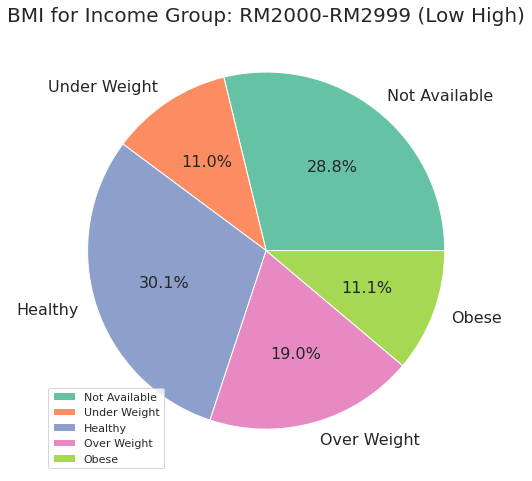

In [198]:
# function to get pie chart: distribution of bmi for a particular income group 
def bmi_income_plot(income):
    c = panelists_by_income_bmi.loc[panelists_by_income_bmi.index == income]
    c.T.plot.pie(subplots=True, ylabel='', autopct='%1.1f%%', textprops={'fontsize': 16}, figsize=(8, 12))
    plt.title('BMI for Income Group: ' + str(income), fontsize=20)
    plt.legend(loc='lower left')

# e.g. pie chart for 'RM2000-RM2999 (Low High)'
bmi_income_plot('RM2000-RM2999 (Low High)')

plt.savefig('bmi_income_plot(RM2000-RM2999 (Low High)).png', dpi=300, bbox_inches='tight')

In [199]:
merged_data = pd.merge(transaction_df1, categories, on = "Category", how = "inner")
merged_data['Calories'] = merged_data['Weight']*merged_data['Calories/100g']*10
merged_data = merged_data.groupby(['Panel ID', 'Date']).sum(['Calories']).reset_index().groupby(['Panel ID']).mean(['Calories'])
merged_data = pd.merge(merged_data, panelists_demogs, on = "Panel ID")
merged_data.head()

,Panel ID,Pack Size,Volume,Spend,Weight,Time Elapsed,Calories/100g,Price per Volume,Discretionary,Calories,BMI,Ethnicity,Strata,Location,Lifestage,#HH,Income
0,101011101,6.486726,13.638053,35.984071,11.943540,3985.097345,1062.486726,36.723097,1.300885,30450.920354,Obese,Malay,Urban,North,Empty Nesters,1-3 Member HH,<RM2000 (Low)
1,101016101,5.016129,8.051613,24.375806,7.245161,4037.048387,1215.870968,36.549677,1.870968,21983.774194,Healthy,Malay,Urban,North,Yankys/Matured Families,1-3 Member HH,<RM2000 (Low)
2,101019101,12.829605,28.121711,53.956579,20.498684,11774.526316,2777.611842,115.416513,1.611842,46614.953947,Obese,Malay,Urban,North,Teens Aches,4-5 Member HH,<RM2000 (Low)
3,101024101,7.901316,17.257895,43.178947,12.839211,6917.539474,1633.098684,79.489539,2.532895,28686.881579,Over Weight,Chinese,Urban,North,Nesting Families,1-3 Member HH,<RM2000 (Low)
4,105009103,7.737179,11.568590,28.161538,7.626282,8106.416667,2167.916667,100.603654,1.423077,17996.801282,Over Weight,Malay,Rural,North,Empty Nesters,1-3 Member HH,<RM2000 (Low)


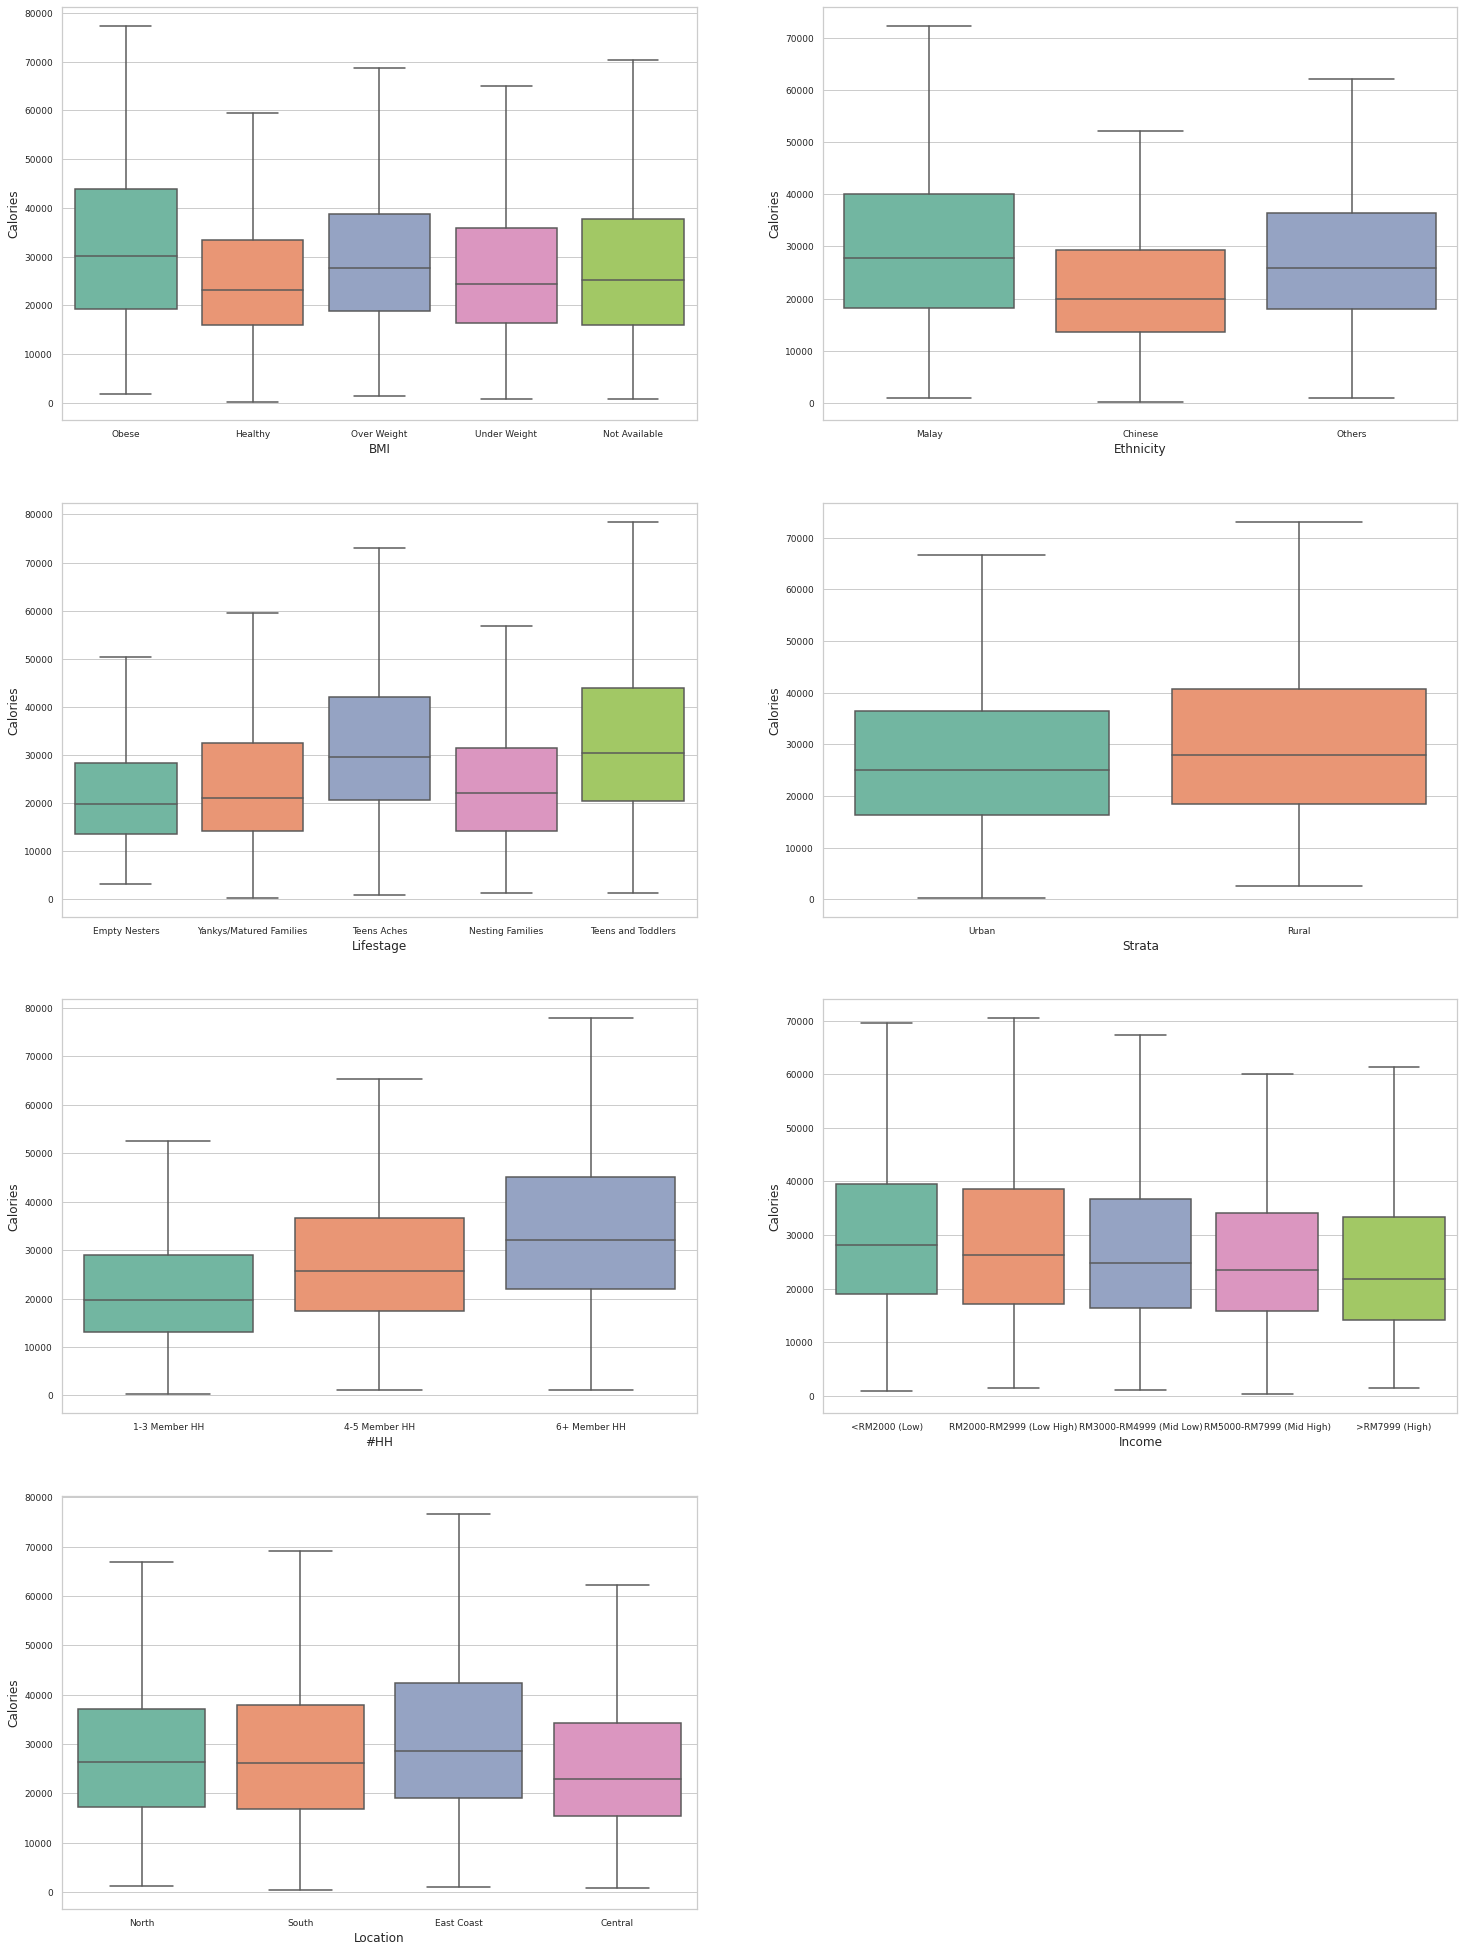

<Figure size 432x288 with 0 Axes>

In [200]:
plt.figure(figsize=(25,35))
sns.set_theme(style="whitegrid", palette="Set2")
i = 0

cols = ['BMI', 'Ethnicity', 'Lifestage', 'Strata', '#HH','Income', 'Location']
for col in cols:
  i = i + 1
  plt.subplot(4,2,i)
  ax = sns.boxplot(x=merged_data[col], y=merged_data['Calories'], showfliers = False)
  ax.tick_params(labelsize = 9)

plt.show()
plt.savefig('box plots.png')
#files.download('box plots.png')

## Panelists Segmentation

### 3.1 CSFH Score

In [201]:
# combining dfs
combined_df1 = pd.merge(transaction_df1, categories, on='Category', how='inner')
combined_df1.shape #no.of rows remains the same
#combined_df1.head()


(1337566, 11)

In [202]:
#add new column for total calories 
combined_df1['Total Calories']=combined_df1['Calories/100g']*combined_df1['Weight']*10 #since weight is in kg
combined_df1.head()

,Panel ID,Date,Category,Pack Size,Volume,Spend,Weight,Time Elapsed,Calories/100g,Price per Volume,Discretionary,Total Calories
0,101011101,2018-04-29,SUGAR,2.0,2.0,5.9,2.0,1093,405,2.99,0,8100.0
1,101011101,2018-05-27,SUGAR,1.0,2.0,5.9,2.0,1093,405,2.99,0,8100.0
2,101011101,2018-07-01,SUGAR,5.0,5.0,13.5,5.0,1093,405,2.99,0,20250.0
3,101011101,2018-08-12,SUGAR,1.0,2.0,5.9,2.0,1093,405,2.99,0,8100.0
4,101011101,2018-08-19,SUGAR,1.0,2.0,5.9,2.0,1093,405,2.99,0,8100.0


In [203]:
#group by ID， date and discretionary indicator
#calculate total spending and calories for transactions on that date
#keep time_elapsed column
combined_df2 = combined_df1.groupby(
    ['Panel ID', 'Date', 'Discretionary'], as_index=False).agg(Spending = pd.NamedAgg('Spend', aggfunc='sum'),
                                              Calories = pd.NamedAgg('Total Calories', aggfunc='sum'),
                                              Time_elapsed = pd.NamedAgg('Time Elapsed', aggfunc='min'))

#total spending and calories for each panelist on each date
combined_df2.head()

,Panel ID,Date,Discretionary,Spending,Calories,Time_elapsed
0,101011101,2018-04-29,0,15.5,9498.0,1093
1,101011101,2018-05-06,0,4.2,156.0,1093
2,101011101,2018-05-06,1,10.0,2646.0,1093
3,101011101,2018-05-13,0,1.5,2.0,1093
4,101011101,2018-05-13,1,3.0,1284.0,1093


In [204]:
#group by ID and discretionary indicator 
#calculate total spending and calories across all dates
#keep time_elapsed column
combined_df3 = combined_df2.groupby(
    ['Panel ID', 'Discretionary'], as_index=False).agg(Date_count = pd.NamedAgg('Date', aggfunc='count'),
                      Spending = pd.NamedAgg('Spending', aggfunc='sum'),
                      Calories = pd.NamedAgg('Calories', aggfunc='sum'),
                      Time_elapsed = pd.NamedAgg('Time_elapsed', aggfunc='min'))

combined_df3.head()

,Panel ID,Discretionary,Date_count,Spending,Calories,Time_elapsed
0,101011101,0,106,3302.0,2858782.0,1093
1,101011101,1,70,764.2,582172.0,1093
2,101016101,0,51,1025.9,969072.0,1093
3,101016101,1,49,485.4,393922.0,1093
4,101019101,0,152,7202.7,4964654.0,1086


In [205]:
#drop rows with  <=5 transaction dates as there is not enough information to determine consumption habits for these consumers
combined_df4 = combined_df3.loc[combined_df3['Date_count'] >5, :]

#group by panel ID and sum the average spending and calories across both discretionary and non-discretionary food, keeping date_count and time_elapsed 
combined_df4 = combined_df4.groupby(
    ['Panel ID'], as_index=False).agg(Date_count = pd.NamedAgg('Date_count', aggfunc='max'),
                      Spending = pd.NamedAgg('Spending', aggfunc='sum'),
                      Calories = pd.NamedAgg('Calories', aggfunc='sum'),
                      Time_elapsed = pd.NamedAgg('Time_elapsed', aggfunc='min'))
    

#Standardise FREQUENCY: date count/time elapsed
combined_df4['Frequency'] = combined_df4['Date_count']/combined_df4['Time_elapsed']
combined_df4

,Panel ID,Date_count,Spending,Calories,Time_elapsed,Frequency
0,101011101,106,4066.2,3440954.0,1093,0.096981
1,101016101,51,1511.3,1362994.0,1093,0.046661
2,101019101,152,8201.4,7085473.0,1086,0.139963
3,101024101,149,6563.2,4360406.0,1093,0.136322
4,105009103,156,4393.2,2807501.0,1093,0.142726
...,...,...,...,...,...,...
3431,802294401,8,469.4,156269.0,50,0.160000
3432,802294601,7,168.8,95734.0,50,0.140000
3433,802296701,6,170.8,62481.0,43,0.139535
3434,802298101,7,427.9,208986.0,43,0.162791


In [206]:
#dataframe only for transactions that involve discretionary food groups
disc_df = combined_df3.loc[combined_df3['Date_count'] >5, :]

disc_df = disc_df[disc_df['Discretionary']==1]

disc_df = disc_df.rename(columns = {'Calories':'Disc Calories'})

#we only need the calories 
disc_df.drop(['Discretionary', 'Date_count', 'Spending', 'Time_elapsed'], axis=1, inplace=True)

In [207]:
disc_df

,Panel ID,Disc Calories
1,101011101,582172.0
3,101016101,393922.0
5,101019101,2120819.0
7,101024101,1992402.0
9,105009103,368907.0
...,...,...
7742,802290801,78568.0
7744,802293801,141580.0
7746,802294201,199278.0
7748,802294401,22586.0


In [208]:
#combining overall df and discretionary food group df
combined_df5 = pd.merge(combined_df4, disc_df, on='Panel ID', how='left')
#for those who did not consume any discretionary food, fill_na by 0
combined_df5['Disc Calories'].fillna(0, inplace=True)

#calculate the proportion of total calories that come from discretionary food group
combined_df5['Disc Calories Proportion']=combined_df5['Disc Calories']/combined_df5['Calories']

#get mean Spending and mean Calories per transaction date 
combined_df5['Spending'] = combined_df5['Spending']/combined_df5['Date_count']
combined_df5['Calories'] = combined_df5['Calories']/combined_df5['Date_count']


combined_df5.drop(['Disc Calories', 'Date_count', 'Time_elapsed'], axis=1, inplace=True)

In [209]:
combined_df5.describe()

,Spending,Calories,Frequency,Disc Calories Proportion
count,3436.000000,3436.000000,3436.000000,3436.000000
mean,54.907726,30569.011315,0.099637,0.325810
std,30.556089,17377.918184,0.030405,0.170942
min,5.450000,1235.000000,0.009724,0.000000
25%,35.144363,18645.375000,0.077768,0.212346
50%,48.896272,27206.007226,0.102470,0.314085
75%,66.594975,38699.338235,0.124088,0.425212
max,288.848592,158561.659574,0.166667,1.000000


**CSFH Model:**

Using CSFH score to quantify panelists' consumption habits

*   C: Calories Score
> Average calories that are contained in the packaged food purchased in transactions within a day 

*   S: Spending Score
> Average spending on packaged food


*   F: Frequency Score
> Frequency of purchasing packaged food: unique date count/time elapsed


*   H: Health Score
> What proportion of the calories come from items in discretionary food groups? (the higher the proportion, the less health conscious the panelist)







In [210]:
CSFH_model = combined_df5.copy()
CSFH_model

,Panel ID,Spending,Calories,Frequency,Disc Calories Proportion
0,101011101,38.360377,32461.830189,0.096981,0.169189
1,101016101,29.633333,26725.372549,0.046661,0.289012
2,101019101,53.956579,46614.953947,0.139963,0.299319
3,101024101,44.048322,29264.469799,0.136322,0.456930
4,105009103,28.161538,17996.801282,0.142726,0.131400
...,...,...,...,...,...
3431,802294401,58.675000,19533.625000,0.160000,0.144533
3432,802294601,24.114286,13676.285714,0.140000,0.000000
3433,802296701,28.466667,10413.500000,0.139535,0.000000
3434,802298101,61.128571,29855.142857,0.162791,0.358048


In [211]:
CSFH_model.describe()

,Spending,Calories,Frequency,Disc Calories Proportion
count,3436.000000,3436.000000,3436.000000,3436.000000
mean,54.907726,30569.011315,0.099637,0.325810
std,30.556089,17377.918184,0.030405,0.170942
min,5.450000,1235.000000,0.009724,0.000000
25%,35.144363,18645.375000,0.077768,0.212346
50%,48.896272,27206.007226,0.102470,0.314085
75%,66.594975,38699.338235,0.124088,0.425212
max,288.848592,158561.659574,0.166667,1.000000


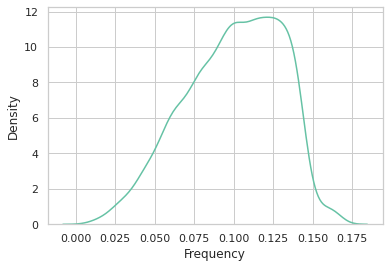

In [212]:
sns.kdeplot(x=CSFH_model['Frequency'])
plt.savefig('frequency.png', dpi=300, bbox_inches='tight')
#files.download('frequency.png')

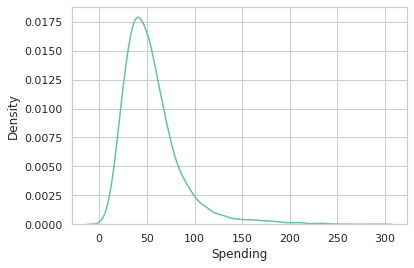

In [213]:
sns.kdeplot(x=CSFH_model['Spending'])
plt.savefig('spending.png', dpi=300, bbox_inches='tight')
#files.download('spending.png')

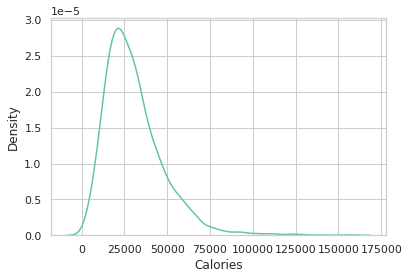

In [214]:
sns.kdeplot(x=CSFH_model['Calories'])
plt.savefig('calories.png', dpi=300, bbox_inches='tight')
#files.download('calories.png')

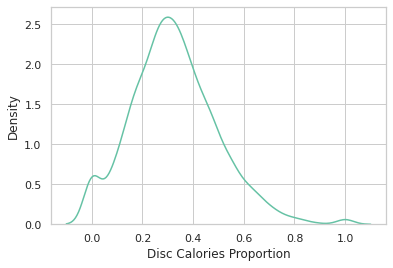

In [215]:
#for health score
sns.kdeplot(x=CSFH_model['Disc Calories Proportion'])
plt.savefig('Disc Calories Proportion.png', dpi=300, bbox_inches='tight')
#files.download('Disc Calories Proportion.png')

In [216]:
quantiles = CSFH_model.quantile(q=[0.2,0.4,0.6,0.8]) # Get a dataframe of quantiles for each column
quantiles = quantiles.to_dict() #Convert the dataframe into a nested dictionary of quantiles

In [217]:
quantiles

{'Calories': {0.2: 16806.666666666668,
  0.4: 23568.202702702703,
  0.6: 31195.90625,
  0.8: 42237.048},
 'Disc Calories Proportion': {0.2: 0.18646084120004455,
  0.4: 0.27620159593816695,
  0.6: 0.3533069411251233,
  0.8: 0.4587021936799229},
 'Frequency': {0.2: 0.071875,
  0.4: 0.09392265193370165,
  0.6: 0.11148272017837235,
  0.8: 0.12844036697247707},
 'Spending': {0.2: 32.27123287671233,
  0.4: 43.052499999999995,
  0.6: 54.679591836734694,
  0.8: 71.72727272727273}}

In [218]:
def Hscore(value,label,dictionary):   #Functions to get the H scores. For H scores, 
                                        #the higher the value, the more health-conscious someone is
    if value <= dictionary[label][0.2]:
        return 5
    elif value <= dictionary[label][0.4]:
        return 4
    elif value <= dictionary[label][0.6]:
        return 3
    elif value <= dictionary[label][0.8]:
        return 2
    else:
        return 1

def CSFscores(value,label,dictionary):     #Function to get C, S and F scores. the higher the value, the more frequent and the more money 
    if value <= dictionary[label][0.2]:   #has been spent and the more calories consumed
        return 1
    elif value <= dictionary[label][0.4]:
        return 2
    elif value <= dictionary[label][0.6]:
        return 3
    elif value <= dictionary[label][0.8]:
        return 4
    else:
        return 5

In [219]:
#Apply a function along a column of the dataFrame.
#For each row, check the column value and see which bin it belongs to
CSFH_model['C'] = CSFH_model['Calories'].apply(CSFscores,args=('Calories',quantiles))
CSFH_model['S'] = CSFH_model['Spending'].apply(CSFscores,args=('Spending',quantiles))
CSFH_model['F'] = CSFH_model['Frequency'].apply(CSFscores,args=('Frequency',quantiles))
CSFH_model['H'] = CSFH_model['Disc Calories Proportion'].apply(Hscore,args=('Disc Calories Proportion',quantiles))

CSFH_model['CSFH'] = CSFH_model.C.map(lambda x: x*1000) + CSFH_model.S.map(lambda x:x*100) + CSFH_model.F.map(lambda x:x*10) + CSFH_model.H
CSFH_model.tail(10)

,Panel ID,Spending,Calories,Frequency,Disc Calories Proportion,C,S,F,H,CSFH
3426,802289901,21.850000,14541.125000,0.160000,0.549717,1,1,5,1,1151
3427,802290101,77.962500,27762.000000,0.160000,0.000000,3,5,5,5,3555
3428,802290801,53.200000,27181.428571,0.162791,0.412929,3,3,5,2,3352
3429,802293801,54.087500,38942.875000,0.160000,0.454448,4,3,5,2,4352
3430,802294201,80.714286,51638.857143,0.162791,0.551296,5,5,5,1,5551
3431,802294401,58.675000,19533.625000,0.160000,0.144533,2,4,5,5,2455
3432,802294601,24.114286,13676.285714,0.140000,0.000000,1,1,5,5,1155
3433,802296701,28.466667,10413.500000,0.139535,0.000000,1,1,5,5,1155
3434,802298101,61.128571,29855.142857,0.162791,0.358048,3,4,5,2,3452
3435,802299701,64.300000,4344.500000,0.093750,0.000000,1,4,2,5,1425


### 3.2 Segmenting Consumers

#### Health-conscious vs Non Health-conscious

We want to target consumers with high C score and low H score (consuming a lot of calories and most of the foods they consume consist of those in discretionary food groups).

If someone's C score >=4 and H score <=2, we consider him to be unhealthy

In [220]:
#creating label for unhealthy consumers
CSFH_model['Non health-conscious'] = 0
#if someone's C score >=4 and H score <=2, we consider him to be unhealthy
CSFH_model['Non health-conscious'].loc[(CSFH_model['C']>=4) | (CSFH_model['H']<=2)]=1

Merging CSFH data with demographics data:

In [221]:
CSFH_model1 = CSFH_model.drop(['Spending', 'Calories', 'Frequency', 'Disc Calories Proportion'], axis=1)

In [222]:
joined_df = pd.merge(panelists_demogs, CSFH_model1, on='Panel ID', how='inner')
joined_df.shape

(3435, 14)

In [223]:
joined_df[joined_df['Non health-conscious']==1]

,Panel ID,BMI,Ethnicity,Strata,Location,Lifestage,#HH,Income,C,S,F,H,CSFH,Non health-conscious
0,101011101,Obese,Malay,Urban,North,Empty Nesters,1-3 Member HH,<RM2000 (Low),4,2,3,5,4235,1
2,101019101,Obese,Malay,Urban,North,Teens Aches,4-5 Member HH,<RM2000 (Low),5,3,5,3,5353,1
3,101024101,Over Weight,Chinese,Urban,North,Nesting Families,1-3 Member HH,<RM2000 (Low),3,3,5,2,3352,1
7,105021106,Obese,Malay,Rural,North,Yankys/Matured Families,4-5 Member HH,RM3000-RM4999 (Mid Low),5,4,5,5,5455,1
9,105031104,Over Weight,Malay,Rural,North,Teens Aches,4-5 Member HH,<RM2000 (Low),4,2,3,5,4235,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3425,802289901,Not Available,Malay,Urban,Central,Teens Aches,4-5 Member HH,RM2000-RM2999 (Low High),1,1,5,1,1151,1
3427,802290801,Not Available,Malay,Urban,North,Nesting Families,1-3 Member HH,RM2000-RM2999 (Low High),3,3,5,2,3352,1
3428,802293801,Not Available,Malay,Urban,South,Teens and Toddlers,4-5 Member HH,<RM2000 (Low),4,3,5,2,4352,1
3429,802294201,Not Available,Malay,Urban,Central,Teens and Toddlers,4-5 Member HH,RM3000-RM4999 (Mid Low),5,5,5,1,5551,1


2163 out of 3435 consumers are not health-conscious enough and we choose this consumer segment as our target audience. 

#### Among the non health-conscious ones: segmentation by income

We further segment the targeted non health-conscious consumers based on income:

In [224]:
target_df = joined_df.loc[joined_df['Non health-conscious']==1,]

In [225]:
target_low_income = target_df.loc[(target_df['Income']=='<RM2000 (Low)')|(target_df['Income']=='RM2000-RM2999 (Low High)'),]

target_mid_income = target_df.loc[(target_df['Income']=='RM3000-RM4999 (Mid Low)')|(target_df['Income']=='RM5000-RM7999 (Mid High)'),]

target_high_income = target_df.loc[target_df['Income']=='>RM7999 (High)',]

In [226]:
print("There are " + str(len(target_low_income)) + " consumers in the low income target group")
print("There are " + str(len(target_mid_income)) + " consumers in the mid income target group")
print("There are " + str(len(target_high_income)) + " consumers in the high income target group")


There are 976 consumers in the low income target group
There are 977 consumers in the mid income target group
There are 210 consumers in the high income target group


In [227]:
print("The mean Spending score for consumers in low income target group is " + str(target_low_income['S'].mean()))
print("The mean Spending score for consumers in mid income target group is " + str(target_mid_income['S'].mean()))
print("The mean Spending score for consumers in high income target group is " + str(target_high_income['S'].mean()))

The mean Spending score for consumers in low income target group is 3.1506147540983607
The mean Spending score for consumers in mid income target group is 3.4790174002047083
The mean Spending score for consumers in high income target group is 3.757142857142857


We observe that the average SPENDING scores are possitive correlated with income: consumers with higher income tend to spend more.

In [228]:
print("The mean Health score for consumers in low income target group is " + str(target_low_income['H'].mean()))
print("The mean Health score for consumers in mid income target group is " + str(target_mid_income['H'].mean()))
print("The mean Health score for consumers in high income target group is " + str(target_high_income['H'].mean()))

The mean Health score for consumers in low income target group is 2.5706967213114753
The mean Health score for consumers in mid income target group is 2.212896622313204
The mean Health score for consumers in high income target group is 2.204761904761905


We observe that the average HEALTH scores are negatively correlated with income: consumers with higher income tend to consume more foods from the discretionary food groups.

In [229]:
print("The mean Calories score for consumers in low income target group is " + str(target_low_income['C'].mean()))
print("The mean Calories score for consumers in mid income target group is " + str(target_mid_income['C'].mean()))
print("The mean Calories score for consumers in high income target group is " + str(target_high_income['C'].mean()))

The mean Calories score for consumers in low income target group is 3.752049180327869
The mean Calories score for consumers in mid income target group is 3.433981576253838
The mean Calories score for consumers in high income target group is 3.342857142857143


We observe that the average CALORIES scores are negatively correlated with income: consumers with higher income tend to consume fewer calories on average.

In [230]:
print("The mean Frequency score for consumers in low income target group is " + str(target_low_income['F'].mean()))
print("The mean Frequency score for consumers in mid income target group is " + str(target_mid_income['F'].mean()))
print("The mean Frequency score for consumers in high income target group is " + str(target_high_income['F'].mean()))

The mean Frequency score for consumers in low income target group is 3.1024590163934427
The mean Frequency score for consumers in mid income target group is 2.9969293756397133
The mean Frequency score for consumers in high income target group is 2.8333333333333335


We observe that the average FREQUENCY scores are negatively correlated with income: consumers with higher income tend to visit the supermarket/purchase packaged foods less frequently.

# Recommender System

### 4.1 For Existing Consumers

For existing consumers whose transactions are recorded, we 

In [231]:
!pip install turicreate
!{sys.executable} -m pip install turicreate
import time
import turicreate as tc
from sklearn.model_selection import train_test_split

#### Transaction data for active consumers

In [232]:
transaction_df2 = pd.merge(transaction_df1, CSFH_model1, on='Panel ID', how='inner')
target_transaction_df = transaction_df2[transaction_df2['Non health-conscious']==1]

#transaction df for target consumers only
target_transaction_df.drop(['C','S','F','H','CSFH'], axis=1, inplace=True)


In [233]:
item_count = transaction_df2.groupby(
    ['Panel ID', 'Category']).agg(Count = pd.NamedAgg('Panel ID', aggfunc='count'),
                                  Time_elapsed = pd.NamedAgg('Time Elapsed', aggfunc='min')).reset_index()
item_count.head()

,Panel ID,Category,Count,Time_elapsed
0,101011101,BISCUITS,25,1093
1,101011101,BOUILON,8,1093
2,101011101,BUTTER,4,1093
3,101011101,CAKE,3,1093
4,101011101,CANNED PRODUCT,14,1093


Rank consumers by how frequently they purchase packaged food

In [234]:
panelists_table = item_count.groupby('Panel ID')['Count'].sum().reset_index().sort_values(by='Count',ascending=False)
panelists_table

,Panel ID,Count
1177,314213101,3810
1810,800214401,3568
2017,800619001,3452
1976,800527501,3259
2188,801042601,3111
...,...,...
2898,801941701,13
3381,802253201,11
1887,800304401,10
2484,801548701,10


In [235]:
threshold_panelist = np.quantile(panelists_table['Count'],0.3) 

For our recommender system, we only consider transactions by active consumers (top 70%)

In [236]:
active_panelists = panelists_table[panelists_table['Count'] >= threshold_panelist]

item_count1 = pd.merge(item_count, active_panelists, on='Panel ID', how='inner')

active_panelists.head()
item_count1

,Panel ID,Category,Count_x,Time_elapsed,Count_y
0,101011101,BISCUITS,25,1093,412
1,101011101,BOUILON,8,1093,412
2,101011101,BUTTER,4,1093,412
3,101011101,CAKE,3,1093,412
4,101011101,CANNED PRODUCT,14,1093,412
...,...,...,...,...,...
82836,802275301,SUGAR,1,78,160
82837,802275301,TEA,1,78,160
82838,802275301,TONIC FOOD DRINK,8,78,160
82839,802275301,YOGHURT DRINK,2,78,160


Standardise the count column by dividing by time_elapsed:

In [237]:
item_count1 = item_count1.rename(columns = {'Count_x':'Count'})

item_count1['Standadised Count'] = item_count1['Count']/item_count1['Time_elapsed']

item_count1.drop(['Time_elapsed', 'Count_y'], axis=1, inplace=True)
item_count1

,Panel ID,Category,Count,Standadised Count
0,101011101,BISCUITS,25,0.022873
1,101011101,BOUILON,8,0.007319
2,101011101,BUTTER,4,0.003660
3,101011101,CAKE,3,0.002745
4,101011101,CANNED PRODUCT,14,0.012809
...,...,...,...,...
82836,802275301,SUGAR,1,0.012821
82837,802275301,TEA,1,0.012821
82838,802275301,TONIC FOOD DRINK,8,0.102564
82839,802275301,YOGHURT DRINK,2,0.025641


#### Consumer-Item Matrix

In [238]:
count_matrix = pd.pivot_table(item_count1, values='Count', index='Panel ID', columns='Category')
count_matrix

Category,BEER,BELACAN,BIRD NEST,BISCUITS,BOUILON,BUTTER,CAKE,CANNED PRODUCT,CEREAL BEVERAGE,CEREALS,CHEESE,CHICKEN ESSENCE,CHOC/NUT SPREAD,CHOCOLATE,COCONUT MILK,COFFEE,CONDENSED/EVAP MILK,CONFECTIONERY,COOKING OILS,COOKING SAUCES,CORDIALS,CREAMER,CSD,CULTURED MILK,DRINKING WATER,EGGS,ENERGY DRINKS,FROZEN FOOD,FRUIT/VEG JUICES,GHEE,HONEY,ICE CREAM,INSTANT NOODLES,INSTANT SOUP,ISOTONIC DRINKS,JAM,KAYA,LIQUID MILK,MARGARINE,MILK POWDER-ADULT,MILK POWDER-INFANT,MILK POWDER-KIDS,MSG,PEANUT BUTTER,PLANT BASED MILK,RICE,RTD COFFEE,RTD TEA,SALAD DRESSING,SAVOURY SPREAD,SEASONING POWDER,SNACK,SOY MILK,SPAGETTI,SPIRITS,SUGAR,TEA,TONIC FOOD DRINK,WINE,YOGHURT DRINK,YOGHURTS
Panel ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
101011101,NaN,NaN,NaN,25.0,8.0,4.0,3.0,14.0,2.0,2.0,2.0,NaN,NaN,2.0,24.0,15.0,16.0,NaN,24.0,36.0,7.0,NaN,5.0,4.0,9.0,15.0,NaN,7.0,3.0,NaN,NaN,3.0,19.0,NaN,NaN,2.0,NaN,2.0,9.0,2.0,NaN,NaN,3.0,NaN,NaN,31.0,NaN,3.0,3.0,NaN,22.0,12.0,4.0,1.0,NaN,63.0,NaN,6.0,NaN,NaN,NaN
101016101,NaN,NaN,NaN,14.0,17.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,1.0,1.0,20.0,NaN,21.0,41.0,5.0,NaN,NaN,NaN,NaN,4.0,NaN,2.0,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,3.0,6.0,3.0,NaN,NaN,NaN,NaN,NaN,22.0,NaN,NaN,1.0,NaN,9.0,1.0,NaN,NaN,NaN,27.0,NaN,18.0,NaN,NaN,NaN
101019101,NaN,1.0,1.0,40.0,NaN,NaN,2.0,20.0,NaN,2.0,NaN,NaN,NaN,8.0,131.0,287.0,49.0,NaN,70.0,13.0,12.0,NaN,3.0,8.0,NaN,254.0,NaN,10.0,2.0,NaN,NaN,2.0,107.0,NaN,6.0,NaN,1.0,3.0,4.0,NaN,NaN,NaN,10.0,1.0,NaN,97.0,NaN,1.0,NaN,NaN,96.0,10.0,NaN,NaN,NaN,254.0,3.0,133.0,NaN,5.0,2.0
101024101,NaN,NaN,NaN,75.0,2.0,NaN,4.0,77.0,5.0,7.0,12.0,NaN,NaN,NaN,1.0,26.0,NaN,8.0,19.0,27.0,NaN,NaN,11.0,47.0,NaN,55.0,NaN,147.0,11.0,NaN,NaN,6.0,95.0,1.0,12.0,NaN,NaN,15.0,8.0,NaN,NaN,NaN,17.0,1.0,NaN,27.0,3.0,9.0,8.0,1.0,2.0,141.0,13.0,10.0,NaN,11.0,5.0,34.0,NaN,6.0,3.0
105009103,NaN,NaN,NaN,82.0,9.0,NaN,NaN,89.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,137.0,NaN,12.0,153.0,57.0,7.0,NaN,NaN,NaN,24.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,37.0,NaN,7.0,NaN,NaN,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,207.0,NaN,9.0,NaN,NaN,12.0,NaN,137.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802255201,2.0,NaN,NaN,24.0,3.0,NaN,NaN,4.0,NaN,1.0,2.0,NaN,NaN,3.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,6.0,2.0,11.0,NaN,14.0,NaN,NaN,NaN,NaN,11.0,NaN,3.0,1.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,25.0,1.0,3.0,NaN,NaN,NaN,2.0,NaN,NaN,9.0
802257301,NaN,2.0,NaN,12.0,NaN,NaN,NaN,10.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,5.0,7.0,5.0,9.0,8.0,5.0,NaN,2.0,NaN,6.0,8.0,NaN,7.0,1.0,NaN,NaN,3.0,5.0,NaN,6.0,NaN,5.0,6.0,NaN,7.0,NaN,NaN,5.0,NaN,NaN,3.0,2.0,3.0,3.0,NaN,NaN,12.0,3.0,NaN,NaN,10.0,3.0,5.0,NaN,NaN,NaN
802257401,NaN,NaN,NaN,8.0,6.0,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,8.0,3.0,11.0,NaN,6.0,8.0,1.0,NaN,NaN,3.0,NaN,12.0,NaN,7.0,NaN,1.0,1.0,1.0,10.0,NaN,NaN,NaN,NaN,7.0,3.0,2.0,NaN,10.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,7.0,3.0,NaN,6.0,NaN,7.0,4.0,3.0,NaN,NaN,NaN


Normalise purchase frequency of each item across consumers:

In [239]:
#NORMALISE
count_matrix_norm = (count_matrix-count_matrix.min())/(count_matrix.max()-count_matrix.min())

# create a table for input to the modeling
d = count_matrix_norm.reset_index() 
d.index.names = ['Normalized count'] 
count_norm = pd.melt(d, id_vars=['Panel ID'], value_name='Normalised count').dropna()
print(count_norm.shape)
count_norm.head()

(82841, 3)


,Panel ID,Category,Normalised count
21,106014103,BEER,0.002469
22,106016101,BEER,0.000000
23,106023104,BEER,0.009877
24,106024101,BEER,0.009877
25,106059101,BEER,0.002469


#### Split train and test set

In [240]:
def split_data(data):
    '''
    Splits dataset into training and test set.
    
    Args:
        data (pandas.DataFrame)
        
    Returns
        train_data (tc.SFrame)
        test_data (tc.SFrame)
    '''
    train, test = train_test_split(data, test_size = .2, random_state=42)
    train_data = tc.SFrame(train)
    test_data = tc.SFrame(test)
    return train_data, test_data

In [241]:
train_data, test_data = split_data(count_norm)

#### Item-based Collaborative Filtering Models using Turicreate library

This model first computes the similarity between items using the observations of users who have purchased both items. Given a similarity between item **i** and **j**: **S(i,j)**, it scores an item **j** for user **u** using a weighted average of the user’s previous observations **I_u**.

In [242]:
def model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display):
    if name == 'cosine':
        model = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='cosine')
    elif name == 'pearson':
        model = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='pearson')
        
    recom = model.recommend(users=users_to_recommend, k=n_rec)
    recom.print_rows(n_display)
    return model

In [243]:
# constant variables to define field names include:
user_id = 'Panel ID'
item_id = 'Category'
customers = pd.DataFrame(transaction_df['Panel ID'].unique())
users_to_recommend = list(customers[0])
n_rec = 10 # number of items to recommend
n_display = 30 # to display the first few rows in an output dataset


In [244]:
name = 'cosine'
target = 'Normalised count'
cosine_model = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 66272 observations with 2413 users and 61 items.

Data prepared in: 0.199561s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.624ms                        | 41.25      |

| 5.62ms                         | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 6.668ms                             | 0                | 0               |

| 43.24ms                             | 100              | 61              |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.052741s

recommendations finished on 1000/3917 queries. users per second: 13094.8

recommendations finished on 2000/3917 queries. users per second: 13208.3

recommendations finished on 3000/3917 queries. users per second: 14319.1

+-----------+---------------------+----------------------+------+
|  Panel ID |       Category      |        score         | rank |
+-----------+---------------------+----------------------+------+
| 101011101 |   INSTANT NOODLES   | 0.022165287818227495 |  1   |
| 101011101 |         EGGS        | 0.021762928792408535 |  2   |
| 101011101 | CONDENSED/EVAP MILK | 0.02171660533973149  |  3   |
| 101011101 |   SEASONING POWDER  | 0.01975647040775844  |  4   |
| 101011101 |        COFFEE       | 0.01855183712073735  |  5   |
| 101011101 |         TEA         | 0.017929590174130032 |  6   |
| 101011101 |     FROZEN FOOD     | 0.017711437174252102 |  7   |
| 101011101 |         CSD         | 0.01434549263545445  |  8   |
| 101011101 |   ISOTONIC DRINKS   | 0.013267425554139274 |  9   |
| 101011101 |    PEANUT BUTTER    | 0.012938863464764186 |  10  |
| 101016101 |    COOKING SAUCES   | 0.018022222651375666 |  1   |
| 101016101 |         RICE        | 0.017946263154347736 |  2   |
| 10101610

In [245]:
name = 'pearson'
target = 'Normalised count'
pearson_model = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 66272 observations with 2413 users and 61 items.

Data prepared in: 0.173335s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 9.038ms                        | 41.25      |

| 23.539ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 24.661ms                            | 0                | 0               |

| 111.218ms                           | 100              | 61              |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.136203s

recommendations finished on 1000/3917 queries. users per second: 46622.2

recommendations finished on 2000/3917 queries. users per second: 43994.7

recommendations finished on 3000/3917 queries. users per second: 43472

+-----------+---------------------+---------------------+------+
|  Panel ID |       Category      |        score        | rank |
+-----------+---------------------+---------------------+------+
| 101011101 |   INSTANT NOODLES   |  0.1289210628751222 |  1   |
| 101011101 |         EGGS        | 0.11428466366850897 |  2   |
| 101011101 |   PLANT BASED MILK  | 0.11415477352482929 |  3   |
| 101011101 |       CREAMER       | 0.10613864628875841 |  4   |
| 101011101 |      BIRD NEST      | 0.10314551824396781 |  5   |
| 101011101 |  MILK POWDER-INFANT |  0.0816962430295265 |  6   |
| 101011101 |         WINE        | 0.07414391425513567 |  7   |
| 101011101 |     FROZEN FOOD     |  0.0720024481774752 |  8   |
| 101011101 |   MILK POWDER-KIDS  | 0.06214260228194873 |  9   |
| 101011101 | CONDENSED/EVAP MILK | 0.06208695791009852 |  10  |
| 101016101 |   INSTANT NOODLES   | 0.12312124852599311 |  1   |
| 101016101 |   PLANT BASED MILK  | 0.11408037297309388 |  2   |
| 101016101 |       CREAM

In [246]:
models = [cosine_model, pearson_model]
names = ['Cosine Similarity on Scaled Purchase Counts', 'Pearson Similarity on Scaled Purchase Counts']

Evaluate the models:

In [247]:
eval_models = tc.recommender.util.compare_models(test_data, models, model_names=names)

PROGRESS: Evaluate model Cosine Similarity on Scaled Purchase Counts


recommendations finished on 1000/2405 queries. users per second: 34922.3

recommendations finished on 2000/2405 queries. users per second: 33323.9


Precision and recall summary statistics by cutoff
+--------+--------------------+---------------------+
| cutoff |   mean_precision   |     mean_recall     |
+--------+--------------------+---------------------+
|   1    | 0.9185031185031185 | 0.15682526355603266 |
|   2    | 0.8613305613305613 | 0.28454455800609657 |
|   3    | 0.7975051975051973 | 0.38325250171404035 |
|   4    | 0.7435550935550934 | 0.46747549920626846 |
|   5    | 0.691392931392932  |  0.5346551554243867 |
|   6    | 0.6436590436590436 |  0.5901216524293453 |
|   7    | 0.6052272052272055 |  0.6413910967757123 |
|   8    | 0.5663721413721413 |  0.6799069699069701 |
|   9    | 0.5346731346731343 |  0.7187109050570587 |
|   10   | 0.5064864864864866 |  0.7524335574335572 |
+--------+--------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.09746254486491313

Per User RMSE (best)
+-----------+----------------------+-------+
|  Panel ID |         rmse         | count |
+-----------+----------

recommendations finished on 1000/2405 queries. users per second: 40191.3

recommendations finished on 2000/2405 queries. users per second: 36599.2


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4523908523908523 | 0.07055861152015007 |
|   2    |  0.327234927234927  | 0.10002454348608195 |
|   3    |  0.2658350658350655 | 0.11965963812117661 |
|   4    |  0.2773388773388774 | 0.17335638604869374 |
|   5    |  0.2999584199584198 |  0.2349788874788876 |
|   6    | 0.30367290367290395 | 0.28170053496976544 |
|   7    | 0.30412830412830405 | 0.32692582134889847 |
|   8    |  0.3036382536382535 |  0.3709918194533579 |
|   9    |  0.3014553014553012 | 0.40951992567377205 |
|   10   |  0.2993762993762992 |  0.4498041367272135 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.08541171490641294

Per User RMSE (best)
+-----------+-----------------------+-------+
|  Panel ID |          rmse         | count |
+------

From the evaluation we can see that the precision and recall for Cosine Model are much higher than for Pearson Model.

Pearson Model has a slightly lower RMSE than Cosine Model.

Overall, Cosine Model performs better and we choose it as the model used for our recommender system.

#### Final Recommender System

In [248]:
recom = cosine_model.recommend(users=users_to_recommend, k=n_rec)
df_rec = recom.to_dataframe()
print(df_rec.shape)
df_rec.head()

recommendations finished on 1000/3917 queries. users per second: 34633.2

recommendations finished on 2000/3917 queries. users per second: 33492.4

recommendations finished on 3000/3917 queries. users per second: 34137.8

(39170, 4)


,Panel ID,Category,score,rank
0,101011101,INSTANT NOODLES,0.022165,1
1,101011101,EGGS,0.021763,2
2,101011101,CONDENSED/EVAP MILK,0.021717,3
3,101011101,SEASONING POWDER,0.019756,4
4,101011101,COFFEE,0.018552,5


In [249]:
url5 = 'https://docs.google.com/spreadsheets/d/1amEBh292mblrjyYQj8zd43UNlFQ_Zscj/edit?usp=sharing&ouid=101560640057754598043&rtpof=true&sd=true'
path5 = 'https://drive.google.com/uc?export=download&id='+url5.split('/')[-2]

health_alternative_categories = pd.read_excel(path5)

For categories that belong to discretionary food groups, we provide a list of healthier alternatves that would be recommended to the consumers instead:

In [250]:
health_alternative_categories.dropna(axis=0, inplace=True)

#converting category to capital letters
health_alternative_categories['Category'] = health_alternative_categories['Category'].apply(lambda Category : Category.upper())
health_alternative_categories['Alternative'] = health_alternative_categories['Alternative'].apply(lambda Alternative : Alternative.upper())

health_alternative_categories.drop(['Calories/100g', 'Price per Volume'], axis=1, inplace=True)
health_alternative_categories.head()

,Category,Alternative
1,BELACAN,LOW SODIUM BELACAN
3,BISCUITS,WHOLEMEAL BISCUITS
4,BOUILON,LOW SODIUM BOUILON
6,CAKE,LOW SUGAR CAKE
8,CEREAL BEVERAGE,OATMEAL


In [251]:
health_alternative_dict = pd.Series(health_alternative_categories.Alternative.values,index=health_alternative_categories.Category).to_dict()

health_alternative_dict

{'BELACAN': 'LOW SODIUM BELACAN',
 'BISCUITS': 'WHOLEMEAL BISCUITS',
 'BOUILON': 'LOW SODIUM BOUILON',
 'CAKE': 'LOW SUGAR CAKE',
 'CEREAL BEVERAGE': 'OATMEAL',
 'CHOC/NUT SPREAD': 'NUT PASTES (NO ADDED SUGAR, SALT)',
 'CONDENSED/EVAP MILK': 'MILK',
 'CONFECTIONERY': 'SUGAR FREE CONFECTIONARY ',
 'COOKING SAUCES': 'LOW SODIUM COOKING SAUCES',
 'CORDIALS': 'LOW SUGAR CORDIALS',
 'CREAMER': 'LOW FAT CREAMER',
 'CSD': 'CSD WITH STEVIA',
 'ICE CREAM': 'LOW FAT ICE CREAM',
 'INSTANT NOODLES': 'WHOLEGRAIN NOODLES',
 'INSTANT SOUP': 'LOW SODIUM INSTANT SOUP',
 'JAM': 'JAM (NO SUGAR ADDED)',
 'KAYA': 'LOW SUGAR KAYA ',
 'MARGARINE': 'OLIVE OIL',
 'PEANUT BUTTER': 'PEANUT BUTTER (NO SUGAR, SALT ADDED)',
 'SAVOURY SPREAD': 'SAVOURY SPREAD (LOW SODIUM, LOW FAT)',
 'SNACK': 'LOW CALORIES SNACK'}

In [252]:
for i in df_rec['Category']:
      if i in health_alternative_dict.keys():
        df_rec['Category'].replace(i,health_alternative_dict[i], inplace=True)

df_rec 
#final recommendation df consisting of healthier alternatives for food in discretionary food groups

,Panel ID,Category,score,rank
0,101011101,WHOLEGRAIN NOODLES,0.022165,1
1,101011101,EGGS,0.021763,2
2,101011101,MILK,0.021717,3
3,101011101,SEASONING POWDER,0.019756,4
4,101011101,COFFEE,0.018552,5
...,...,...,...,...
39165,802315301,MILK,0.016754,6
39166,802315301,EGGS,0.016742,7
39167,802315301,TONIC FOOD DRINK,0.016415,8
39168,802315301,LOW CALORIES SNACK,0.016353,9


In [253]:
def healthy_recomendation_by_ID(panel_id):
    rec = df_rec.loc[df_rec['Panel ID'] == panel_id]
    return rec

healthy_recomendation_by_ID('101011101')

,Panel ID,Category,score,rank
0,101011101,WHOLEGRAIN NOODLES,0.022165,1
1,101011101,EGGS,0.021763,2
2,101011101,MILK,0.021717,3
3,101011101,SEASONING POWDER,0.019756,4
4,101011101,COFFEE,0.018552,5
5,101011101,TEA,0.017930,6
6,101011101,FROZEN FOOD,0.017711,7
7,101011101,CSD WITH STEVIA,0.014345,8
8,101011101,ISOTONIC DRINKS,0.013267,9
9,101011101,"PEANUT BUTTER (NO SUGAR, SALT ADDED)",0.012939,10


### 4.2 For New Consumers

For new consumers, since we do not have any transaction data, we use decision tree model to predict whether they are likely to be health conscious or not based on their demographics and provide recommendations accordingly.

In [254]:
!pip install category_encoders
!pip install xgboost
!{sys.executable} -m pip install category_encoders
!{sys.executable} -m pip install xgboost
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import category_encoders as ce
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score,precision_score,roc_auc_score,recall_score,confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import graphviz
from sklearn.utils import shuffle
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree

In [255]:
#we will use recoded BMI values (from 2.3 KModes)
dataset = joined_df.drop(['C','H','S','F','CSFH', 'BMI'], axis=1)
panelists_demogs1['Panel ID']=panelists_demogs1.index
panelists_demogs1.reset_index(drop=True, inplace=True)

recoded_BMI = panelists_demogs1.loc[:,['Panel ID','BMI']]

dataset = pd.merge(dataset, recoded_BMI, on='Panel ID', how='inner')

In [256]:
dataset.to_excel('updated_data.xlsx')

In [257]:
# Data resampling
df_s1 = dataset[dataset['Non health-conscious'] == 1]
df_s2 = dataset[dataset['Non health-conscious'] == 0]
count = max(df_s1.count()[0], df_s2.count()[0])
df_s1 = resample(df_s1, replace=df_s1.count()[0] < count, n_samples=count, random_state=0)
df_s2 = resample(df_s2, replace=df_s2.count()[0] < count, n_samples=count, random_state=0)
joined_df1 = pd.concat([df_s1, df_s2])
joined_df1

,Panel ID,Ethnicity,Strata,Location,Lifestage,#HH,Income,Non health-conscious,BMI
1737,800177501,Malay,Urban,East Coast,Teens and Toddlers,4-5 Member HH,RM3000-RM4999 (Mid Low),1,Over Weight
2701,801717901,Malay,Rural,East Coast,Yankys/Matured Families,4-5 Member HH,RM2000-RM2999 (Low High),1,Healthy
1586,458072101,Others,Rural,East Coast,Yankys/Matured Families,4-5 Member HH,RM3000-RM4999 (Mid Low),1,Obese
2774,801796501,Malay,Urban,South,Yankys/Matured Families,6+ Member HH,RM2000-RM2999 (Low High),1,Obese
2942,801977401,Malay,Urban,South,Yankys/Matured Families,1-3 Member HH,<RM2000 (Low),1,Healthy
...,...,...,...,...,...,...,...,...,...
378,160001101,Others,Urban,North,Empty Nesters,1-3 Member HH,<RM2000 (Low),0,Over Weight
1714,800167101,Malay,Urban,East Coast,Yankys/Matured Families,1-3 Member HH,RM3000-RM4999 (Mid Low),0,Healthy
1294,332257101,Malay,Urban,South,Teens and Toddlers,6+ Member HH,RM3000-RM4999 (Mid Low),0,Under Weight
2007,800590101,Malay,Urban,Central,Nesting Families,1-3 Member HH,<RM2000 (Low),0,Healthy


In [258]:
#Drop Household due to it being correlated to Lifestage
joined_df1.drop('#HH', inplace=True, axis=1)
joined_df1.drop('Panel ID', inplace=True, axis=1)
joined_df1

,Ethnicity,Strata,Location,Lifestage,Income,Non health-conscious,BMI
1737,Malay,Urban,East Coast,Teens and Toddlers,RM3000-RM4999 (Mid Low),1,Over Weight
2701,Malay,Rural,East Coast,Yankys/Matured Families,RM2000-RM2999 (Low High),1,Healthy
1586,Others,Rural,East Coast,Yankys/Matured Families,RM3000-RM4999 (Mid Low),1,Obese
2774,Malay,Urban,South,Yankys/Matured Families,RM2000-RM2999 (Low High),1,Obese
2942,Malay,Urban,South,Yankys/Matured Families,<RM2000 (Low),1,Healthy
...,...,...,...,...,...,...,...
378,Others,Urban,North,Empty Nesters,<RM2000 (Low),0,Over Weight
1714,Malay,Urban,East Coast,Yankys/Matured Families,RM3000-RM4999 (Mid Low),0,Healthy
1294,Malay,Urban,South,Teens and Toddlers,RM3000-RM4999 (Mid Low),0,Under Weight
2007,Malay,Urban,Central,Nesting Families,<RM2000 (Low),0,Healthy


In [259]:
#Categories to one hot encode
races = joined_df1.Ethnicity.unique() #Comprise of Malay, Chinese and Others -> 1, 0, 2
strata = joined_df1.Strata.unique() # Comprise of Urban and Rural
location = joined_df1.Location.unique() # Comprise of North, South, East Coast and Central -> 2, 

In [260]:
avail_columns = list(joined_df1.columns)
for i in [0, 1, 2, 3, 4, 6]:
  do_chisquare = joined_df1.iloc[:, [i,5]]
  print(do_chisquare)
  attr = avail_columns[i]
  print("\n----------------------------" + attr + "------------------------------------------------------")
  chisquare_crosstab = pd.crosstab(do_chisquare[attr],
                            do_chisquare['Non health-conscious'],
                           margins=True, margins_name="Total")
  alpha = 0.05
  chi_square = 0
  rows = do_chisquare[attr].unique()
  columns = do_chisquare['Non health-conscious'].unique()
  for i in columns:
    for j in rows:
      O = chisquare_crosstab[i][j]
      E = chisquare_crosstab[i]['Total'] * chisquare_crosstab['Total'][j] / chisquare_crosstab['Total']['Total']
      chi_square += (O-E)**2/E
  print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
  p_value = 1 - stats.norm.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
  conclusion = "Failed to reject the null hypothesis."
  if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
  print("chisquare-score is:", chi_square, " and p value is:", p_value)
  print(conclusion)

  print("--------------------------------------------------------------------------------------")
  print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
  critical_value = stats.chi2.ppf(1-alpha, (len(rows)-1)*(len(columns)-1))
  conclusion = "Failed to reject the null hypothesis."
  if chi_square > critical_value:
    conclusion = "Null Hypothesis is rejected."
  print("chisquare-score is:", chi_square, " and p value is:", critical_value)
  print(conclusion)

     Ethnicity  Non health-conscious
1737     Malay                     1
2701     Malay                     1
1586    Others                     1
2774     Malay                     1
2942     Malay                     1
...        ...                   ...
378     Others                     0
1714     Malay                     0
1294     Malay                     0
2007     Malay                     0
3085   Chinese                     0

[4326 rows x 2 columns]

----------------------------Ethnicity------------------------------------------------------
Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 16.667787301435265  and p value is: 0.0
Null Hypothesis is rejected.
--------------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing in the decision rule
chisquare-score is: 16.667787301435265  and p value is: 5.991464547107979
Null Hypothesis is rejected.


In [261]:
joined_df1.drop('Strata', inplace=True, axis=1)
labelencoder = LabelEncoder()
joined_df1["Ethnicity"] = labelencoder.fit_transform(joined_df1["Ethnicity"])
joined_df1["Location"] = labelencoder.fit_transform(joined_df1["Location"])

In [262]:
#Categories to ordinal encode
lifestage = joined_df1.Lifestage.unique()
income = joined_df1.Income.unique()
bmi = joined_df1.BMI.unique()

print(lifestage)
print(income)
print(bmi)

['Teens and Toddlers' 'Yankys/Matured Families' 'Teens Aches'
 'Empty Nesters' 'Nesting Families']
['RM3000-RM4999 (Mid Low)' 'RM2000-RM2999 (Low High)' '<RM2000 (Low)'
 'RM5000-RM7999 (Mid High)' '>RM7999 (High)']
['Over Weight' 'Healthy' 'Obese' 'Under Weight']


In [263]:
lifestage_dict = [{'col': 'Lifestage', 'mapping': {'Empty Nesters': 1, 'Teens and Toddlers': 2, 'Teens Aches': 3,  'Nesting Families': 4, 'Yankys/Matured Families': 5}}]
income_dict = [{'col': 'Income', 'mapping': {'<RM2000 (Low)': 1, 'RM2000-RM2999 (Low High)': 2, 'RM3000-RM4999 (Mid Low)': 3, 'RM5000-RM7999 (Mid High)': 4, '>RM7999 (High)': 5}}]
bmi_dict = [{'col': 'BMI', 'mapping': {'Under Weight': 1, 'Healthy': 2, 'Over Weight': 3, 'Obese': 4}}]

lifestage_encoder = ce.OrdinalEncoder(cols = 'Lifestage', mapping = lifestage_dict)
income_encoder = ce.OrdinalEncoder(cols = 'Income', mapping = income_dict)
bmi_encoder = ce.OrdinalEncoder(cols = 'BMI', mapping = bmi_dict)

In [264]:
joined_df1 = lifestage_encoder.fit_transform(joined_df1)
joined_df1 = income_encoder.fit_transform(joined_df1)
joined_df1 = bmi_encoder.fit_transform(joined_df1)
joined_df1

,Ethnicity,Location,Lifestage,Income,Non health-conscious,BMI
1737,1,1,2,3,1,3
2701,1,1,5,2,1,2
1586,2,1,5,3,1,4
2774,1,3,5,2,1,4
2942,1,3,5,1,1,2
...,...,...,...,...,...,...
378,2,2,1,1,0,3
1714,1,1,5,3,0,2
1294,1,3,2,3,0,1
2007,1,0,4,1,0,2


In [265]:
target_prediction = joined_df1['Non health-conscious'].values
X = joined_df1.drop(labels = ['Non health-conscious'], axis = 1)
x_train, x_test, y_train, y_test = train_test_split(X, target_prediction, test_size=0.25, random_state = 20)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning:

Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning:

Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning:

Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning:

Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning:

Crit

Best max_depth for mse: 9
Best max_depth for mae: 6


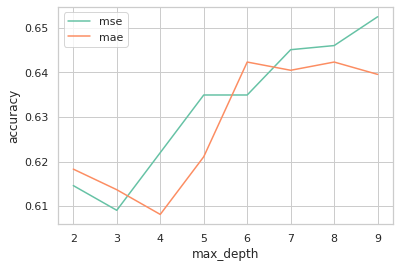

In [266]:
max_depth = []
acc_mse = []
acc_mae = []
for i in range(2,10):
    dtree = GradientBoostingClassifier(criterion = 'mse', max_features = 'sqrt', subsample = 0.85, max_depth=i)
    dtree.fit(x_train, y_train)
    pred = dtree.predict(x_test)
    acc_mse.append(accuracy_score(y_test, pred))
    ###
    dtree2 = GradientBoostingClassifier(criterion = 'mae', max_features = 'sqrt', subsample = 0.85, max_depth=i)
    dtree2.fit(x_train, y_train)
    pred = dtree2.predict(x_test)
    acc_mae.append(accuracy_score(y_test, pred))
    ####
    max_depth.append(i)
d = pd.DataFrame({'acc_mse':pd.Series(acc_mse), 
    'acc_mae':pd.Series(acc_mae),
    'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
plt.plot('max_depth','acc_mse', data=d, label='mse')
plt.plot('max_depth','acc_mae', data=d, label='mae')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
print("Best max_depth for mse:", d.sort_values('acc_mse',ascending=False).iloc[0,2])
print("Best max_depth for mae:", d.sort_values('acc_mae',ascending=False).iloc[0,2])

Decision Tree

In [267]:
clf_gbm = GradientBoostingClassifier(criterion = 'mse', max_features = 'sqrt', subsample = 0.85, max_depth = 6)
clf_gbm.fit(x_train, y_train)
y_pred = clf_gbm.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:475: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed i

In [268]:
def feature_imp(model):
    a=dict(zip(x_train.columns, model.feature_importances_.round(3)))
    b = dict()
    for key, value in a.items():
        if value > 0 :
            b[key] = value

    return sorted(b.items(), key=lambda x: x[1],reverse=True)


y_pred = clf_gbm.predict(x_test)

y_pred_train = clf_gbm.predict(x_train)

cm = pd.DataFrame(confusion_matrix(y_pred_train, y_train))
cm.columns = ['True Y=0','True Y=1']
cm.index = ['Predicted Y=0','Predicted Y=1']
display(cm)
specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0])
print("Accuracy:",round(accuracy_score(y_train, y_pred_train),4))
print('Precision:', round(precision_score(y_train, y_pred_train),4))
print('Specificity:', round(specificity, 4))
print('Sensitivity',round(recall_score(y_train, y_pred_train),4))
print('F1-Score:', round(f1_score(y_train, y_pred_train),4))
print('AUC:',round(roc_auc_score(y_train, y_pred_train),4))
feature_imp(clf_gbm)

,True Y=0,True Y=1
Predicted Y=0,1107,437
Predicted Y=1,537,1163


Accuracy: 0.6998
Precision: 0.6841
Specificity: 0.6734
Sensitivity 0.7269
F1-Score: 0.7048
AUC: 0.7001


[('Lifestage', 0.28),
 ('Income', 0.248),
 ('Location', 0.179),
 ('BMI', 0.172),
 ('Ethnicity', 0.121)]

Random Forest

In [269]:
modelRF = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 20) # Can have more trees by changing the values of n_estimators
modelRF.fit(x_train, y_train)
y_predRF = modelRF.predict(x_test)

In [270]:
cmRF = pd.DataFrame(confusion_matrix(y_predRF, y_test))
cmRF.columns = ['True Y=0','True Y=1']
cmRF.index = ['Predicted Y=0','Predicted Y=1']
display(cmRF)
specificity = cmRF.iloc[0, 0]/(cmRF.iloc[0, 0] + cmRF.iloc[1, 0])
print("Accuracy:",round(accuracy_score(y_test, y_predRF),4))
print('Precision:', round(precision_score(y_test, y_predRF),4))
print('Specificity:', round(specificity,4))
print('Sensitivity',round(recall_score(y_test, y_predRF),4))
print('F1-Score:', round(f1_score(y_test, y_predRF),4))
print('AUC:',round(roc_auc_score(y_test, y_predRF),4))

,True Y=0,True Y=1
Predicted Y=0,327,203
Predicted Y=1,192,360


Accuracy: 0.6349
Precision: 0.6522
Specificity: 0.6301
Sensitivity 0.6394
F1-Score: 0.6457
AUC: 0.6347


XGBoost

In [271]:
xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(x_train, y_train)
y_predXGB = xgb_cl.predict(x_test)

In [272]:
cmXGB = pd.DataFrame(confusion_matrix(y_predXGB, y_test))
cmXGB.columns = ['True Y=0','True Y=1']
cmXGB.index = ['Predicted Y=0','Predicted Y=1']
display(cmXGB)
specificity = cmXGB.iloc[0, 0]/(cmXGB.iloc[0, 0] + cmXGB.iloc[1, 0])
print("Accuracy:",round(accuracy_score(y_test, y_predXGB), 4))
print('Precision:', round(precision_score(y_test, y_predXGB), 4))
print('Specificity:', round(specificity, 4))
print('Sensitivity',round(recall_score(y_test, y_predXGB), 4))
print('F1-Score:', round(f1_score(y_test, y_predXGB), 4))
print('AUC:',round(roc_auc_score(y_test, y_predXGB), 4))

,True Y=0,True Y=1
Predicted Y=0,322,217
Predicted Y=1,197,346


Accuracy: 0.6174
Precision: 0.6372
Specificity: 0.6204
Sensitivity 0.6146
F1-Score: 0.6257
AUC: 0.6175


In [276]:
feature_cols = x_train.columns.tolist()
dotfile = open("tree.dot", 'w')
tree.export_graphviz(clf_gbm[99,0], out_file = dotfile,
                     feature_names=feature_cols,
                     class_names = [str(i) for i in clf_gbm[99,0].classes_],
                     proportion=False)
dotfile.close()

AttributeError: ignored

In [274]:
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)

NameError: ignored


# Media Plan

First, we will compile the time spent on the respective mediums and the various platforms and multiply them together.


For example, if a panelist has TV frequency of 4 and Disney frequency of 2, his/her score for Disney will be 8.

We do this for TV, Internet, Radio, from which we select the 3 most popular platform/channel **amongst customers who are not health concious enough** for each location

After scaling the respective scores, we will combine them.

For newspaper, for each area, we will use the section that is most commonly read by customers of the area, since we don't have frequnecy data but only whether they read particular sections of the newspaper.

## TV channels

Independent time spent on each channel 

In [278]:
tv_channels = survey[['v_83','v_84','v_85','v_86','v_82','v_70','v_71','v_72','v_73','v_74','v_88','v_89','v_90','v_76','v_77','v_78','v_79','v_80','v_92','v_93','v_94','v_96','v_97','v_98','v_100','v_101','v_102','v_104','v_105','v_106','v_62','v_63','v_64','v_65','v_66','v_67','v_68']]
tv_channels.columns = ['CITRA','OASIS','PRIMA','RIA','WARNA','AEC','AOD','CELESTIAL MOVIES','HUA HEE DAI','TVB JADE','CINEMAX','FOX','HBO','ADITHYA','STAR VIJAY','SUN TV','VELLIATHIRAI','VINMEEN','KBS','ONE','TVN','AWANI','CHANNEL NEWS ASIA','CNN','ARENA','ASSP','WWE','CARTOON NETWORK','CERIA','DISNEY','TV ALHIJRAH','TV1','TV2','TV3','NTV7','8TV','TV9']
tv_channels

,CITRA,OASIS,PRIMA,RIA,WARNA,AEC,AOD,CELESTIAL MOVIES,HUA HEE DAI,TVB JADE,CINEMAX,FOX,HBO,ADITHYA,STAR VIJAY,SUN TV,VELLIATHIRAI,VINMEEN,KBS,ONE,TVN,AWANI,CHANNEL NEWS ASIA,CNN,ARENA,ASSP,WWE,CARTOON NETWORK,CERIA,DISNEY,TV ALHIJRAH,TV1,TV2,TV3,NTV7,8TV,TV9
0,1.0,1.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,4.0,4.0,1.0,1.0,4.0
1,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,2.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0
3,1.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,4.0,4.0,4.0,1.0,4.0
4,1.0,1.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886,3.0,2.0,2.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,3.0,1.0,1.0,3.0,3.0,3.0,2.0,2.0
1887,3.0,4.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,3.0,3.0,1.0,3.0,1.0,1.0,1.0,4.0,2.0,4.0,4.0,1.0,1.0,1.0
1888,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,4.0,1.0,1.0,3.0
1889,3.0,3.0,3.0,3.0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,3.0,3.0,1.0,1.0,1.0,3.0,3.0,1.0,3.0,1.0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,3.0,3.0,4.0


Accounting for time spent on TV : Multiply time spent on TV as weight, row wise


In [279]:
tv_channels_by_frequency = tv_channels.mul(media_final['TV'].tolist(), axis = 0)
tv_channels_by_frequency.insert(0,'Panel ID',survey['ID'], True)
tv_channels_by_frequency

,Panel ID,CITRA,OASIS,PRIMA,RIA,WARNA,AEC,AOD,CELESTIAL MOVIES,HUA HEE DAI,TVB JADE,CINEMAX,FOX,HBO,ADITHYA,STAR VIJAY,SUN TV,VELLIATHIRAI,VINMEEN,KBS,ONE,TVN,AWANI,CHANNEL NEWS ASIA,CNN,ARENA,ASSP,WWE,CARTOON NETWORK,CERIA,DISNEY,TV ALHIJRAH,TV1,TV2,TV3,NTV7,8TV,TV9
0,426187101.0,7.0,7.0,14.0,21.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,21.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,21.0,28.0,28.0,28.0,7.0,7.0,28.0
1,203116101.0,7.0,7.0,7.0,7.0,7.0,21.0,7.0,7.0,7.0,21.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,21.0,28.0,14.0
2,248111101.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,14.0,14.0,7.0
3,201019101.0,7.0,28.0,28.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,28.0,7.0,7.0,28.0,7.0,7.0,7.0,7.0,7.0,28.0,28.0,28.0,28.0,28.0,7.0,28.0
4,246226102.0,5.0,5.0,5.0,5.0,5.0,15.0,5.0,15.0,20.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,20.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886,802186201.0,21.0,14.0,14.0,21.0,21.0,7.0,7.0,7.0,7.0,7.0,21.0,21.0,21.0,7.0,7.0,7.0,7.0,7.0,21.0,28.0,21.0,7.0,7.0,7.0,7.0,7.0,7.0,21.0,28.0,21.0,7.0,7.0,21.0,21.0,21.0,14.0,14.0
1887,802188101.0,21.0,28.0,28.0,28.0,28.0,7.0,7.0,7.0,7.0,7.0,7.0,28.0,28.0,28.0,28.0,7.0,7.0,7.0,7.0,7.0,7.0,28.0,7.0,21.0,21.0,7.0,21.0,7.0,7.0,7.0,28.0,14.0,28.0,28.0,7.0,7.0,7.0
1888,802188801.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,21.0,21.0,21.0,28.0,7.0,7.0,21.0
1889,802189701.0,18.0,18.0,18.0,18.0,18.0,6.0,6.0,18.0,6.0,6.0,18.0,18.0,18.0,6.0,6.0,6.0,18.0,18.0,6.0,18.0,6.0,18.0,6.0,6.0,18.0,6.0,6.0,18.0,18.0,18.0,18.0,24.0,24.0,24.0,18.0,18.0,24.0


## Internet websites

Independent time spent on each website 


In [280]:
internet_websites = survey[['v_161','v_162','v_163','v_165','v_166','v_168','v_169','v_170','v_172','v_173','v_175','v_176','v_177','v_179','v_181','v_182','v_183']]
internet_websites.columns = ['facebook frequency','gmail frequency','google frequency','insta frequency','lazada frequency','taobao frequency','lowyat frequency','malaysiakini frequency','mudah frequency','netflix frequency','shoppee frequency','sinarharian frequency','thestar','twitter frequency','whatsapp frequency','yahoo frequency','youtube frequency']
internet_websites

,facebook frequency,gmail frequency,google frequency,insta frequency,lazada frequency,taobao frequency,lowyat frequency,malaysiakini frequency,mudah frequency,netflix frequency,shoppee frequency,sinarharian frequency,thestar,twitter frequency,whatsapp frequency,yahoo frequency,youtube frequency
0,1.0,7.0,7.0,7.0,2.0,7.0,7.0,7.0,7.0,7.0,2.0,7.0,7.0,7.0,1.0,7.0,1.0
1,1.0,2.0,2.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,1.0,7.0,1.0
2,1.0,2.0,2.0,6.0,2.0,2.0,6.0,6.0,6.0,6.0,2.0,7.0,7.0,7.0,1.0,2.0,2.0
3,1.0,3.0,1.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,1.0,1.0,6.0
4,1.0,1.0,1.0,1.0,1.0,7.0,7.0,7.0,6.0,7.0,1.0,7.0,7.0,7.0,1.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886,1.0,1.0,4.0,4.0,4.0,7.0,7.0,7.0,4.0,7.0,4.0,7.0,7.0,7.0,1.0,7.0,2.0
1887,6.0,7.0,6.0,7.0,5.0,7.0,7.0,7.0,5.0,7.0,7.0,7.0,7.0,7.0,1.0,7.0,7.0
1888,1.0,7.0,6.0,7.0,6.0,7.0,7.0,7.0,7.0,7.0,6.0,7.0,7.0,7.0,1.0,7.0,1.0
1889,1.0,1.0,1.0,1.0,6.0,7.0,7.0,1.0,6.0,6.0,3.0,1.0,7.0,7.0,1.0,2.0,1.0


Here, standardization of frequencies is required across all websites

In [281]:
i = 0
for i in range(0,17):
    internet_websites.iloc[:,i] = internet_websites.iloc[:,i].map(standardize_freq)
    i += 1
internet_websites

,facebook frequency,gmail frequency,google frequency,insta frequency,lazada frequency,taobao frequency,lowyat frequency,malaysiakini frequency,mudah frequency,netflix frequency,shoppee frequency,sinarharian frequency,thestar,twitter frequency,whatsapp frequency,yahoo frequency,youtube frequency
0,7,1,1,1,6,1,1,1,1,1,6,1,1,1,7,1,7
1,7,6,6,1,1,1,1,1,1,1,1,1,1,1,7,1,7
2,7,6,6,2,6,6,2,2,2,2,6,1,1,1,7,6,6
3,7,5,7,1,1,1,1,1,1,1,1,1,1,1,7,7,2
4,7,7,7,7,7,1,1,1,2,1,7,1,1,1,7,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886,7,7,4,4,4,1,1,1,4,1,4,1,1,1,7,1,6
1887,2,1,2,1,3,1,1,1,3,1,1,1,1,1,7,1,1
1888,7,1,2,1,2,1,1,1,1,1,2,1,1,1,7,1,7
1889,7,7,7,7,2,1,1,7,2,2,5,7,1,1,7,6,7


In [282]:
internet_websites_by_frequency = internet_websites.mul(media_final['Internet'].tolist(), axis = 0)
internet_websites_by_frequency.insert(0,'Panel ID',survey['ID'], True)
internet_websites_by_frequency

,Panel ID,facebook frequency,gmail frequency,google frequency,insta frequency,lazada frequency,taobao frequency,lowyat frequency,malaysiakini frequency,mudah frequency,netflix frequency,shoppee frequency,sinarharian frequency,thestar,twitter frequency,whatsapp frequency,yahoo frequency,youtube frequency
0,426187101.0,49,7,7,7,42,7,7,7,7,7,42,7,7,7,49,7,49
1,203116101.0,49,42,42,7,7,7,7,7,7,7,7,7,7,7,49,7,49
2,248111101.0,49,42,42,14,42,42,14,14,14,14,42,7,7,7,49,42,42
3,201019101.0,49,35,49,7,7,7,7,7,7,7,7,7,7,7,49,49,14
4,246226102.0,49,49,49,49,49,7,7,7,14,7,49,7,7,7,49,7,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886,802186201.0,49,49,28,28,28,7,7,7,28,7,28,7,7,7,49,7,42
1887,802188101.0,14,7,14,7,21,7,7,7,21,7,7,7,7,7,49,7,7
1888,802188801.0,49,7,14,7,14,7,7,7,7,7,14,7,7,7,49,7,49
1889,802189701.0,49,49,49,49,14,7,7,49,14,14,35,49,7,7,49,42,49


We need to scale the scores for Internet websites, since their maximum score is 7x7 = 49, while other mediums are at most 7x4 = 28 only.

In [283]:
internet_websites_by_frequency.iloc[:,1:18] = internet_websites_by_frequency.iloc[:,1:18].apply(lambda x:x * 4/7)
internet_websites_by_frequency

,Panel ID,facebook frequency,gmail frequency,google frequency,insta frequency,lazada frequency,taobao frequency,lowyat frequency,malaysiakini frequency,mudah frequency,netflix frequency,shoppee frequency,sinarharian frequency,thestar,twitter frequency,whatsapp frequency,yahoo frequency,youtube frequency
0,426187101.0,28.0,4.0,4.0,4.0,24.0,4.0,4.0,4.0,4.0,4.0,24.0,4.0,4.0,4.0,28.0,4.0,28.0
1,203116101.0,28.0,24.0,24.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,28.0,4.0,28.0
2,248111101.0,28.0,24.0,24.0,8.0,24.0,24.0,8.0,8.0,8.0,8.0,24.0,4.0,4.0,4.0,28.0,24.0,24.0
3,201019101.0,28.0,20.0,28.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,28.0,28.0,8.0
4,246226102.0,28.0,28.0,28.0,28.0,28.0,4.0,4.0,4.0,8.0,4.0,28.0,4.0,4.0,4.0,28.0,4.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886,802186201.0,28.0,28.0,16.0,16.0,16.0,4.0,4.0,4.0,16.0,4.0,16.0,4.0,4.0,4.0,28.0,4.0,24.0
1887,802188101.0,8.0,4.0,8.0,4.0,12.0,4.0,4.0,4.0,12.0,4.0,4.0,4.0,4.0,4.0,28.0,4.0,4.0
1888,802188801.0,28.0,4.0,8.0,4.0,8.0,4.0,4.0,4.0,4.0,4.0,8.0,4.0,4.0,4.0,28.0,4.0,28.0
1889,802189701.0,28.0,28.0,28.0,28.0,8.0,4.0,4.0,28.0,8.0,8.0,20.0,28.0,4.0,4.0,28.0,24.0,28.0


## Radio Stations

Independent Radio Station Frequencies

In [284]:
radio_stations = survey[['dupl1_v_210','dupl1_v_211','dupl1_v_212','v_213','v_214','v_215','dupl1_v_216','v_761','v_762','v_763','v_764','v_765','v_767','v_768','v_770','v_771','v_772','v_773','v_774','v_775']]
radio_stations.columns = ['era','thr gegar','sinar fm','hot fm','suria fm','best fm','ikim fm','my fm','988','one fm','melody','go xuan','thr raaga','minnal fm','hitz fm','lite fm','fly fm','mix fm','others','others specified']
radio_stations

,era,thr gegar,sinar fm,hot fm,suria fm,best fm,ikim fm,my fm,988,one fm,melody,go xuan,thr raaga,minnal fm,hitz fm,lite fm,fly fm,mix fm,others,others specified
0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,4.0,3.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,NaN
3,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,arena
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886,4.0,3.0,3.0,4.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,NaN
1887,3.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
1888,3.0,1.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
1889,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN


Accounting for Radio Frequency : Multiply row-wise

In [285]:
radio_stations_by_frequency = radio_stations.mul(media_final['Radio'].tolist(), axis = 0)
radio_stations_by_frequency.insert(0,'Panel ID',survey['ID'], True)
radio_stations_by_frequency

,Panel ID,era,thr gegar,sinar fm,hot fm,suria fm,best fm,ikim fm,my fm,988,one fm,melody,go xuan,thr raaga,minnal fm,hitz fm,lite fm,fly fm,mix fm,others,others specified
0,426187101.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,NaN
1,203116101.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,9.0,9.0,9.0,9.0,9.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,NaN
2,248111101.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,15.0,15.0,20.0,15.0,10.0,5.0,5.0,10.0,10.0,10.0,10.0,5.0,NaN
3,201019101.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,28.0,arenaarenaarenaarenaarenaarenaarena
4,246226102.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,12.0,9.0,9.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886,802186201.0,8.0,6.0,6.0,8.0,6.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,6.0,2.0,2.0,2.0,2.0,NaN
1887,802188101.0,21.0,7.0,7.0,7.0,28.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,NaN
1888,802188801.0,21.0,7.0,21.0,21.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,NaN
1889,802189701.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,NaN


## Newspaper Sections


Independent Newspaper Sections Frequencies

In [286]:
newspaper_sections = survey[['v_1154','dupl1_v_229','v_777','v_778','v_779','v_780']]
newspaper_sections.columns = ['intl news','local news','biz news','entertainment','sports','other']
newspaper_sections

,intl news,local news,biz news,entertainment,sports,other
0,1.0,1.0,0.0,1.0,1.0,1.0
1,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1886,0.0,1.0,0.0,1.0,0.0,0.0
1887,1.0,1.0,0.0,1.0,1.0,0.0
1888,NaN,NaN,NaN,NaN,NaN,NaN
1889,1.0,1.0,1.0,1.0,1.0,1.0


We assume NA entries to be 0.

In [287]:
newspaper_sections = newspaper_sections.fillna(0)
newspaper_sections

,intl news,local news,biz news,entertainment,sports,other
0,1.0,1.0,0.0,1.0,1.0,1.0
1,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
1886,0.0,1.0,0.0,1.0,0.0,0.0
1887,1.0,1.0,0.0,1.0,1.0,0.0
1888,0.0,0.0,0.0,0.0,0.0,0.0
1889,1.0,1.0,1.0,1.0,1.0,1.0


Accounting for Newspaper Frequency : Multiply row-wise

In [288]:
newspaper_sections_by_frequency = newspaper_sections.mul(media_final['Newspaper'].tolist(), axis = 0)
newspaper_sections_by_frequency.insert(0,'Panel ID',survey['ID'], True)
newspaper_sections_by_frequency

,Panel ID,intl news,local news,biz news,entertainment,sports,other
0,426187101.0,5.0,5.0,0.0,5.0,5.0,5.0
1,203116101.0,0.0,4.0,0.0,4.0,0.0,0.0
2,248111101.0,2.0,2.0,2.0,2.0,2.0,0.0
3,201019101.0,0.0,7.0,0.0,7.0,0.0,0.0
4,246226102.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1886,802186201.0,0.0,2.0,0.0,2.0,0.0,0.0
1887,802188101.0,3.0,3.0,0.0,3.0,3.0,0.0
1888,802188801.0,0.0,0.0,0.0,0.0,0.0,0.0
1889,802189701.0,3.0,3.0,3.0,3.0,3.0,3.0


## Combining location and media habits of non health concious customers

In [289]:
from functools import reduce

In [290]:
location = joined_df[joined_df['Non health-conscious']==1].iloc[:,[0,4]]
location

,Panel ID,Location
0,101011101,North
2,101019101,North
3,101024101,North
7,105021106,North
9,105031104,North
...,...,...
3425,802289901,Central
3427,802290801,North
3428,802293801,South
3429,802294201,Central


In [291]:
location['Panel ID'] = location['Panel ID'].astype(int)

In [292]:
demo_tv_internet_radio = reduce(lambda left,right: pd.merge(left,right,on='Panel ID'), [location, tv_channels_by_frequency, internet_websites_by_frequency, radio_stations_by_frequency]).dropna()
demo_tv_internet_radio

,Panel ID,Location,CITRA,OASIS,PRIMA,RIA,WARNA,AEC,AOD,CELESTIAL MOVIES,HUA HEE DAI,TVB JADE,CINEMAX,FOX,HBO,ADITHYA,STAR VIJAY,SUN TV,VELLIATHIRAI,VINMEEN,KBS,ONE,TVN,AWANI,CHANNEL NEWS ASIA,CNN,ARENA,ASSP,WWE,CARTOON NETWORK,CERIA,DISNEY,TV ALHIJRAH,TV1,TV2,TV3,NTV7,8TV,TV9,facebook frequency,gmail frequency,google frequency,insta frequency,lazada frequency,taobao frequency,lowyat frequency,malaysiakini frequency,mudah frequency,netflix frequency,shoppee frequency,sinarharian frequency,thestar,twitter frequency,whatsapp frequency,yahoo frequency,youtube frequency,era,thr gegar,sinar fm,hot fm,suria fm,best fm,ikim fm,my fm,988,one fm,melody,go xuan,thr raaga,minnal fm,hitz fm,lite fm,fly fm,mix fm,others,others specified
1,105021106,North,21.0,21.0,21.0,21.0,21.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,21.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,21.0,28.0,21.0,28.0,7.0,7.0,7.0,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,28.0,Perlis FMPerlis FMPerlis FMPerlis FMPerlis FMP...
5,105052101,North,21.0,21.0,21.0,21.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,28.0,28.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,21.0,21.0,21.0,21.0,21.0,14.0,21.0,28.000000,4.000000,4.000000,4.000000,8.000000,4.000000,4.000000,4.000000,4.000000,4.000000,8.000000,4.000000,4.000000,4.000000,28.000000,4.000000,4.000000,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,6.0,Zayan fmZayan fm
10,106024101,North,7.0,7.0,7.0,7.0,7.0,28.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,28.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,21.0,28.0,7.0,28.000000,24.000000,28.000000,12.000000,16.000000,12.000000,4.000000,4.000000,4.000000,4.000000,24.000000,4.000000,4.000000,4.000000,28.000000,4.000000,24.000000,6.0,6.0,6.0,6.0,6.0,6.0,6.0,18.0,18.0,18.0,18.0,12.0,6.0,6.0,18.0,6.0,6.0,6.0,12.0,Ai FMAi FMAi FMAi FMAi FMAi FM
12,106065101,North,21.0,21.0,21.0,21.0,21.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,21.0,7.0,7.0,21.0,7.0,7.0,7.0,21.0,7.0,21.0,21.0,21.0,21.0,14.0,14.0,21.0,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,6.0,6.0,6.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,Radio KlasikRadio Klasik
18,107025101,North,7.0,7.0,21.0,21.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,21.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,28.0,21.0,21.0,28.0,7.0,7.0,7.0,28.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,28.000000,4.000000,4.000000,7.0,21.0,7.0,7.0,28.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,28.0,Kedah FMKedah FMKedah FMKedah FMKedah FMKedah ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,802064301,Central,21.0,7.0,21.0,28.0,28.0,7.0,7.0,7.0,7.0,7.0,21.0,28.0,28.0,7.0,7.0,7.0,28.0,21.0,21.0,21.0,21.0,21.0,7.0,7.0,28.0,21.0,14.0,28.0,28.0,28.0,21.0,21.0,21.0,28.0,7.0,7.0,21.0,28.000000,28.000000,28.000000,28.000000,20.000000,8.000000,8.000000,8.000000,8.000000,12.000000,12.000000,8.000000,8.000000,4.000000,28.000000,8.000000,28.000000,21.0,21.0,21.0,7.0,21.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,21.0,7.0,28.0,7.0,28.0,7.0,21.0,Kool f.mKool f.mKool f.mKool f.mKool f.mKool f...
1140,802085401,South,21.0,21.0,21.0,21.0,21.0,14.0,14.0,21.0,14.0,14.0,21.0,21.0,21.0,14.0,14.0,14.0,14.0,14.0,28.0,28.0,28.0,21.0,14.0,14.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,28.0,21.0,21.0,21.0,28.000000,8.000000,8.000000,8.000000,8

In [293]:
demo_newspaper = reduce(lambda left,right: pd.merge(left,right,on='Panel ID'), [location, newspaper_sections_by_frequency]).dropna()
demo_newspaper

,Panel ID,Location,intl news,local news,biz news,entertainment,sports,other
0,101011101,North,2.0,2.0,0.0,0.0,0.0,2.0
1,105021106,North,7.0,7.0,7.0,0.0,0.0,0.0
2,105044101,North,0.0,0.0,0.0,0.0,0.0,0.0
3,105046101,North,7.0,7.0,7.0,7.0,7.0,0.0
4,105048101,North,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1200,802181601,South,6.0,6.0,0.0,0.0,0.0,0.0
1201,802186201,South,0.0,2.0,0.0,2.0,0.0,0.0
1202,802188101,Central,3.0,3.0,0.0,3.0,3.0,0.0
1203,802188801,Central,0.0,0.0,0.0,0.0,0.0,0.0


Now we have the combined dataframes we want, and we inspect each location.

### North

In [294]:
north_tir1 = demo_tv_internet_radio[demo_tv_internet_radio['Location'] == 'North'].drop(['Panel ID'],axis = 1)
north_newspaper = demo_newspaper[demo_newspaper['Location'] == 'North']

In [295]:
north_tir1.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'whatsapp frequency'

In [296]:
north_tir2 = north_tir1.drop(['whatsapp frequency'],axis = 1)
north_tir2.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'TV3'

In [297]:
north_tir3 = north_tir2.drop(['TV3'],axis = 1)
north_tir3.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'facebook frequency'

In [298]:
north_newspaper.drop(['Panel ID'],axis = 1).mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'local news'

### South

In [299]:
south_tir1 = demo_tv_internet_radio[demo_tv_internet_radio['Location'] == 'South'].drop(['Panel ID'],axis = 1)
south_newspaper = demo_newspaper[demo_newspaper['Location'] == 'South']

In [300]:
south_tir1.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'whatsapp frequency'

In [301]:
south_tir2 = south_tir1.drop(['whatsapp frequency'],axis = 1)
south_tir2.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'TV3'

In [302]:
south_tir3 = south_tir2.drop(['facebook frequency'],axis = 1)
south_tir3.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'TV3'

In [303]:
south_newspaper.drop(['Panel ID'],axis = 1).mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'local news'

### East Coast

In [304]:
east_tir1 = demo_tv_internet_radio[demo_tv_internet_radio['Location'] == 'East Coast'].drop(['Panel ID'], axis = 1)
east_newspaper = demo_newspaper[demo_newspaper['Location'] == 'East Coast']

In [305]:
east_tir1.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'TV3'

In [306]:
east_tir2 = east_tir1.drop(['TV3'],axis = 1)
east_tir2.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'whatsapp frequency'

In [307]:
east_tir3 = east_tir2.drop(['whatsapp frequency'],axis = 1)
east_tir3.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'TV1'

In [308]:
east_newspaper.drop(['Panel ID'],axis = 1).mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'local news'

### Central

In [309]:
central_tir1 = demo_tv_internet_radio[demo_tv_internet_radio['Location'] == 'Central'].drop(['Panel ID'], axis = 1)
central_newspaper = demo_newspaper[demo_newspaper['Location'] == 'Central']

In [310]:
central_tir1.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'whatsapp frequency'

In [311]:
central_tir2 = central_tir1.drop(['whatsapp frequency'],axis = 1)
central_tir2.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'google frequency'

In [312]:
central_tir3 = central_tir2.drop(['facebook frequency'],axis = 1)
central_tir3.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'google frequency'

In [313]:
central_newspaper.drop(['Panel ID'],axis = 1).mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'local news'

## Timing of advertisements

From the above, we see that Internet and TV are the main mediums we should target our media plan at. Hence we further inspect the timings these non health-conscious consumers use these mediums most frequently.


### TV

In [314]:
tv_timings = survey[['v_19','v_20','v_21','v_22','v_23','v_24','v_25','v_26','v_27','v_28','v_29','v_30','v_31','v_32','v_33','v_34','v_35','v_36','v_37','v_38','v_39','v_40','v_41','v_42','v_43','v_44','v_45','v_46','v_47','v_48']]
tv_timings.columns = ['weekday bfast','weekday morning','weekday lunch','weekday before aftnoon','weekday aftnoon','weekday towards evening','weekday prime time','weekday evening','weekday midnigt','weekday early morn','saturday bfast','saturday morning','saturday lunch','saturday before aftnoon','saturday aftnoon','saturday towards evening','saturday prime time','saturday evening','saturday midnight','saturday early morning','sunday bfast','sunday morning','sunday lunch','sunday before aftnoon', 'sunday aftnoon','sunday towards evening','sunday prime time','sunday evening','sunday midnight','sunday early morning']
tv_timings.insert(0,'Panel ID',survey['ID'], True)
tv_timings = tv_timings.dropna()
tv_timings.reset_index(drop = True)

,Panel ID,weekday bfast,weekday morning,weekday lunch,weekday before aftnoon,weekday aftnoon,weekday towards evening,weekday prime time,weekday evening,weekday midnigt,weekday early morn,saturday bfast,saturday morning,saturday lunch,saturday before aftnoon,saturday aftnoon,saturday towards evening,saturday prime time,saturday evening,saturday midnight,saturday early morning,sunday bfast,sunday morning,sunday lunch,sunday before aftnoon,sunday aftnoon,sunday towards evening,sunday prime time,sunday evening,sunday midnight,sunday early morning
0,426187101.0,1.0,3.0,4.0,1.0,1.0,1.0,1.0,4.0,4.0,1.0,1.0,3.0,4.0,1.0,1.0,1.0,1.0,4.0,4.0,1.0,1.0,3.0,4.0,1.0,1.0,1.0,1.0,4.0,4.0,1.0
1,203116101.0,1.0,2.0,2.0,2.0,3.0,3.0,4.0,4.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,3.0,4.0,4.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,3.0,4.0,4.0,2.0,1.0
2,248111101.0,1.0,2.0,2.0,2.0,2.0,3.0,4.0,3.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,4.0,3.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,4.0,3.0,1.0,1.0
3,201019101.0,4.0,4.0,4.0,4.0,3.0,3.0,4.0,4.0,4.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0
4,246226102.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1783,802186201.0,4.0,4.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,1.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,3.0,3.0,1.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,3.0,3.0,1.0
1784,802188101.0,2.0,4.0,2.0,4.0,4.0,2.0,4.0,4.0,2.0,2.0,2.0,4.0,2.0,4.0,4.0,2.0,4.0,4.0,2.0,2.0,2.0,4.0,2.0,2.0,4.0,2.0,4.0,4.0,2.0,2.0
1785,802188801.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,1.0,1.0
1786,802189701.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,3.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,3.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,3.0,1.0


In [315]:
tv_unhealthy = reduce(lambda left,right: pd.merge(left,right,on='Panel ID'), [location, tv_timings]).dropna()
tv_unhealthy1 = tv_unhealthy.drop(['Panel ID'],axis = 1)
tv_unhealthy1

,Location,weekday bfast,weekday morning,weekday lunch,weekday before aftnoon,weekday aftnoon,weekday towards evening,weekday prime time,weekday evening,weekday midnigt,weekday early morn,saturday bfast,saturday morning,saturday lunch,saturday before aftnoon,saturday aftnoon,saturday towards evening,saturday prime time,saturday evening,saturday midnight,saturday early morning,sunday bfast,sunday morning,sunday lunch,sunday before aftnoon,sunday aftnoon,sunday towards evening,sunday prime time,sunday evening,sunday midnight,sunday early morning
0,North,3.0,3.0,1.0,1.0,3.0,1.0,4.0,3.0,1.0,1.0,1.0,3.0,1.0,3.0,3.0,1.0,4.0,3.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,1.0,4.0,3.0,1.0,1.0
1,North,3.0,1.0,1.0,4.0,3.0,3.0,4.0,4.0,1.0,1.0,3.0,1.0,1.0,4.0,4.0,3.0,4.0,4.0,1.0,1.0,3.0,1.0,1.0,4.0,4.0,3.0,4.0,4.0,1.0,1.0
2,North,1.0,2.0,3.0,4.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,3.0,4.0,4.0,3.0,3.0,3.0,3.0,2.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0
3,North,3.0,1.0,3.0,1.0,3.0,3.0,3.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
4,North,1.0,1.0,1.0,1.0,1.0,1.0,4.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,3.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143,South,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,3.0,3.0,4.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0
1144,South,4.0,4.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,1.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,3.0,3.0,1.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,3.0,3.0,1.0
1145,Central,2.0,4.0,2.0,4.0,4.0,2.0,4.0,4.0,2.0,2.0,2.0,4.0,2.0,4.0,4.0,2.0,4.0,4.0,2.0,2.0,2.0,4.0,2.0,2.0,4.0,2.0,4.0,4.0,2.0,2.0
1146,Central,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,1.0,1.0


#### North

In [316]:
north_tv_timings1 = tv_unhealthy1[tv_unhealthy1['Location'] == 'North']
north_tv_timings1.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'weekday prime time'

In [317]:
north_tv_timings2 = north_tv_timings1.drop(['weekday prime time'],axis = 1)
north_tv_timings2.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'saturday prime time'

In [318]:
north_tv_timings3 = north_tv_timings2.drop(['saturday prime time'],axis = 1)
north_tv_timings3.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'sunday prime time'

In [319]:
north_tv_timings4 = north_tv_timings3.drop(['sunday prime time'],axis = 1)
north_tv_timings4.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'weekday evening'

In [320]:
north_tv_timings5 = north_tv_timings4.drop(['weekday evening'],axis = 1)
north_tv_timings5.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'saturday evening'

Thus, the 5 best timings to advertise the app on TV in Northern Malaysia are : 

1. weekday prime time
2. saturday prime time
3. sunday prime time
4. weekday evening
5. saturday evening

#### South

In [321]:
south_tv_timings1 = tv_unhealthy1[tv_unhealthy1['Location'] == 'South']
south_tv_timings1.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'weekday prime time'

In [322]:
south_tv_timings2 = south_tv_timings1.drop(['weekday prime time'],axis = 1)
south_tv_timings2.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'saturday prime time'

In [323]:
south_tv_timings3 = south_tv_timings2.drop(['saturday prime time'],axis = 1)
south_tv_timings3.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'sunday prime time'

In [324]:
south_tv_timings4 = south_tv_timings3.drop(['sunday prime time'],axis = 1)
south_tv_timings4.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'weekday evening'

In [325]:
south_tv_timings5 = south_tv_timings4.drop(['weekday evening'],axis = 1)
south_tv_timings5.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'saturday evening'

Thus, the 5 best timings to advertise the app on TV in Southern Malaysia are : 

1. weekday prime time
2. saturday prime time
3. sunday prime time
4. weekday evening
5. saturday evening

#### East Coast

In [326]:
east_tv_timings1 = tv_unhealthy1[tv_unhealthy1['Location'] == 'East Coast']
east_tv_timings1.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'weekday prime time'

In [327]:
east_tv_timings2 = east_tv_timings1.drop(['weekday prime time'],axis = 1)
east_tv_timings2.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'saturday prime time'

In [328]:
east_tv_timings3 = east_tv_timings2.drop(['saturday prime time'],axis = 1)
east_tv_timings3.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'sunday prime time'

In [329]:
east_tv_timings4 = east_tv_timings3.drop(['sunday prime time'],axis = 1)
east_tv_timings4.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'saturday evening'

In [330]:
east_tv_timings5 = east_tv_timings4.drop(['saturday evening'],axis = 1)
east_tv_timings5.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'sunday evening'

Thus, the 5 best timings to advertise the app on TV in Northern Malaysia are : 

1. weekday prime time
2. saturday prime time
3. sunday prime time
4. saturday evening
5. sunday evening

#### Central

In [331]:
central_tv_timings1 = tv_unhealthy1[tv_unhealthy1['Location'] == 'Central']
central_tv_timings1.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'weekday prime time'

In [332]:
central_tv_timings2 = central_tv_timings1.drop(['weekday prime time'],axis = 1)
central_tv_timings2.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'sunday prime time'

In [333]:
central_tv_timings3 = central_tv_timings2.drop(['sunday prime time'],axis = 1)
central_tv_timings3.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'saturday prime time'

In [334]:
central_tv_timings4 = central_tv_timings3.drop(['saturday prime time'],axis = 1)
central_tv_timings4.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'saturday evening'

In [335]:
central_tv_timings5 = central_tv_timings4.drop(['saturday evening'],axis = 1)
central_tv_timings5.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'weekday evening'

Thus, the 5 best timings to advertise the app on TV in Northern Malaysia are : 

1. weekday prime time
2. sunday prime time
3. saturday prime time
4. saturday evening
5. weekday evening

### Internet

Unlike that of TV, the survey provided for Internet only asks users about their Youtube usage, as opposed to the Internet in general. Hence we assume that users will also use Facebook, Whatsapp and Google at these timings, in addition to just Youtube.

In [336]:
internet_timings = survey[['dupl1_v_136','v_1122','v_1123','v_1124','v_1125','v_1126','v_1127','v_1128','v_1129','v_1130','v_1131','v_1132']]
internet_timings.columns = ['weekday morning','weekday aftnoon','weekday evening','weekday midnight','saturday morning','saturday aftnoon','saturday evening','saturday midnight','sunday morning','sunday aftnoon','sunday evening','sunday midnight']
internet_timings.insert(0,'Panel ID',survey['ID'], True)
internet_timings = internet_timings.dropna()
internet_timings.reset_index(drop = True)

,Panel ID,weekday morning,weekday aftnoon,weekday evening,weekday midnight,saturday morning,saturday aftnoon,saturday evening,saturday midnight,sunday morning,sunday aftnoon,sunday evening,sunday midnight
0,426187101.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0
1,203116101.0,2.0,3.0,3.0,1.0,2.0,3.0,3.0,1.0,2.0,3.0,3.0,1.0
2,248111101.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0
3,201019101.0,1.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,246226102.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646,802182401.0,3.0,2.0,3.0,1.0,1.0,2.0,3.0,1.0,1.0,2.0,3.0,1.0
1647,802186201.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,3.0
1648,802188801.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0
1649,802189701.0,2.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0,3.0,3.0,3.0


In [337]:
internet_unhealthy = reduce(lambda left,right: pd.merge(left,right,on='Panel ID'), [location, internet_timings]).dropna()
internet_unhealthy1 = internet_unhealthy.drop(['Panel ID'],axis = 1)
internet_unhealthy1

,Location,weekday morning,weekday aftnoon,weekday evening,weekday midnight,saturday morning,saturday aftnoon,saturday evening,saturday midnight,sunday morning,sunday aftnoon,sunday evening,sunday midnight
0,North,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0
1,North,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0
2,North,1.0,2.0,2.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,2.0,1.0
3,North,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0
4,North,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,Central,2.0,2.0,3.0,1.0,3.0,3.0,4.0,1.0,2.0,3.0,3.0,1.0
1034,South,2.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0
1035,South,2.0,2.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,3.0
1036,Central,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0


#### North

In [338]:
north_internet_timings1 = internet_unhealthy1[internet_unhealthy1['Location'] == 'North']
north_internet_timings1.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'saturday evening'

In [339]:
north_internet_timings2 = north_internet_timings1.drop(['saturday evening'],axis = 1)
north_internet_timings2.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'sunday evening'

In [340]:
north_internet_timings3 = north_internet_timings2.drop(['sunday evening'],axis = 1)
north_internet_timings3.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'weekday evening'

In [341]:
north_internet_timings4 = north_internet_timings3.drop(['weekday evening'],axis = 1)
north_internet_timings4.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'sunday aftnoon'

In [342]:
north_internet_timings5 = north_internet_timings4.drop(['sunday aftnoon'],axis = 1)
north_internet_timings5.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'saturday aftnoon'

Thus, the 5 best timings to advertise the app on the Internet in Northern Malaysia are : 

1. saturday evening
2. sunday evening
3. weekday evening
4. sunday afternoon
5. saturday afternoon

#### South

In [343]:
south_internet_timings1 = internet_unhealthy1[internet_unhealthy1['Location'] == 'South']
south_internet_timings1.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'saturday evening'

In [344]:
south_internet_timings2 = south_internet_timings1.drop(['saturday evening'],axis = 1)
south_internet_timings2.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'sunday evening'

In [345]:
south_internet_timings3 = south_internet_timings2.drop(['sunday evening'],axis = 1)
south_internet_timings3.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'weekday evening'

In [346]:
south_internet_timings4 = south_internet_timings3.drop(['weekday evening'],axis = 1)
south_internet_timings4.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'saturday aftnoon'

In [347]:
south_internet_timings5 = south_internet_timings4.drop(['saturday aftnoon'],axis = 1)
south_internet_timings5.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'sunday aftnoon'

Thus, the 5 best timings to advertise the app on the Internet in Southern Malaysia are : 

1. saturday evening
2. sunday evening
3. weekday evening
4. saturday afternoon
5. sunday afternoon

#### East Coast

In [348]:
east_internet_timings1 = internet_unhealthy1[internet_unhealthy1['Location'] == 'East Coast']
east_internet_timings1.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'weekday evening'

In [349]:
east_internet_timings2 = east_internet_timings1.drop(['weekday evening'],axis = 1)
east_internet_timings2.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'saturday evening'

In [350]:
east_internet_timings3 = east_internet_timings2.drop(['saturday evening'],axis = 1)
east_internet_timings3.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'sunday evening'

In [351]:
east_internet_timings4 = east_internet_timings3.drop(['sunday evening'],axis = 1)
east_internet_timings4.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'sunday aftnoon'

In [352]:
east_internet_timings5 = east_internet_timings4.drop(['sunday aftnoon'],axis = 1)
east_internet_timings5.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'saturday aftnoon'

Thus, the 5 best timings to advertise the app on the Internet in East Coast Malaysia are : 

1. weekday evening
2. saturday evening
3. sunday evening
4. sunday afternoon
5. saturday afternoon

#### Central

In [353]:
central_internet_timings1 = internet_unhealthy1[internet_unhealthy1['Location'] == 'Central']
central_internet_timings1.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'saturday evening'

In [354]:
central_internet_timings2 = central_internet_timings1.drop(['saturday evening'],axis = 1)
central_internet_timings2.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'sunday evening'

In [355]:
central_internet_timings3 = central_internet_timings2.drop(['sunday evening'],axis = 1)
central_internet_timings3.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'weekday evening'

In [356]:
central_internet_timings4 = central_internet_timings3.drop(['weekday evening'],axis = 1)
central_internet_timings4.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'sunday aftnoon'

In [357]:
central_internet_timings5 = central_internet_timings4.drop(['sunday aftnoon'],axis = 1)
central_internet_timings5.mean(axis = 0).idxmax()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



'saturday aftnoon'

Thus, the 5 best timings to advertise the app on the Internet in Central Malaysia are : 

1. saturday evening
2. sunday evening
3. weekday evening
4. sunday afternoon
5. saturday afternoon